# Install Libraries & Master Functions

In [1]:
# Core modules import
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import random


# Scrap/APIs modules
import requests
from bs4 import BeautifulSoup
import quandl
import investpy
import yfinance as yf


#import missingno as msno
from IPython.core import display as ICD
from datetime import date
from datetime import datetime, timedelta

# Visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl


# Machine learning
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer,StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import linear_model

from sklearn.dummy import DummyRegressor
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.linear_model import SGDRegressor,PassiveAggressiveRegressor
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input,Activation,Embedding,LSTM,Concatenate,Flatten,Dropout,Bidirectional
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam,RMSprop,Nadam 
from tensorflow.keras import callbacks,Sequential
import tensorflow as tf

from scipy import stats

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model,load_model



In [2]:
#input variables
n_features=18    # number of variables we want to auto select from the features pool
first_date_selection = "2013-01-01" # Date from which we want to collect the data
start_year = date(2022, 1, 1)   # start of the current year
size_training_windows = 500
size_test_windows = 100

# Dates features setting

In [3]:
from datetime import date
from datetime import datetime, timedelta

 # Date for feature selection



today = date.today()  
yesterday = today - timedelta(days=1)
fosterday = yesterday - timedelta(days=1)

now = datetime.now()

if now.hour >= 2: #BITCOIN Closes at 2:00 AM Spain time each day
    to_date = yesterday.strftime("%d/%m/%Y") 
    to_date_yf = yesterday.strftime("%Y-%m-%d")
    prediction_day= today.strftime("%d/%m/%Y")
    ET_prediction_day = (today + timedelta(days=1)).strftime("%d/%m/%Y")
else:
    to_date = fosterday.strftime("%d/%m/%Y")
    to_date_yf= fosterday.strftime("%Y-%m-%d")
    prediction_day= yesterday.strftime("%d/%m/%Y")
    ET_prediction_day = (yesterday + timedelta(days=1)).strftime("%d/%m/%Y")


# Functions

In [4]:
# bitinfochart scrap function - source: medium.com

URL_array  = set()
def link2df(URL,col_name,join_df,join=True,check_column=True,check_URL = True,clear_URL_array=False,show_details=False):
    '''This function scraps the given link and returns dataframe
    __________
    Parameters:
        URL(string): URL to be scrapped from bitcoin website
        col_name(string): column name for dataframe
        join_df(variable)= dataframe withwhich output dataframe will be left joined on Date
        join(boolean)= iF True,join, else don't join
        check_column(boolean)= check if column name already exists
        check_URL(boolean)= check if URL is already processed
        clear_URL_array(boolean)= if true URL_processed array will be cleared
        show_details(boolean)= various details wil be printed such as scrapping first and last details, df head & df tail     
        '''
        
    print(f'processing {col_name}')

    #clear URL append array
    if clear_URL_array==True:
        URL_array.clear()

    #set join parameters if false
    if join == False:
        join_df = None
        check_column=False

    #process column name by making it lowercase and replacing spaces,commas, full stops
    col_name = col_name.lower().replace(',','').replace(" ", "_").replace(".", "_")

    #col_name validation if exists already
    if check_column==True and col_name in list(join_df.columns):
        print(f'column {col_name} already esists in dataframe, stopped here')
        return join_df

    #URL validation if processes already
    elif check_URL==True and URL in list(URL_array):
        print(f'{URL} is already processed, stopped here')
        return join_df 

    #web scrapping
    page = requests.get(URL)
    soup = page.content
    soup = str(soup)
    scraped_output = (soup.split('[[')[1]).split('{labels')[0][0:-2]
    if show_details == True:
        print('head')
        print({scraped_output[0:30]})
        print('tail')
        print({scraped_output[-30:]})

    processed_str = scraped_output.replace('new Date(','')
    processed_str = processed_str.replace(')','')
    processed_str = processed_str.replace('[','')
    processed_str = processed_str.replace(']','')
    processed_str = processed_str.replace('"','')

    processed_str_list = processed_str.split(',')
    date_list,data_list = processed_str_list[::2],processed_str_list[1::2]

    #validate column lengths
    if len(date_list)!=len(data_list):
        print(f'date & data length:{len(date_list),len(data_list),len(date_list)==len(data_list)}')

    #convert list data to a dataframe
    if join == False:
        df = pd.DataFrame()
        df['Date'] = pd.to_datetime(date_list)
        df[col_name] = data_list
        URL_array.add(URL)
        if show_details == True:
            print('*'*100)
            print('df head')
            print(df.head(1))
            print('*'*100)
            print('df tail')
            print(df.tail(1))
            print('*'*100)
            print(f'df shape{df.shape}')
            print('='*100)
            
        return df

    elif col_name not in list(join_df.columns) and join == True:
        df = pd.DataFrame()
        df['Date'] = pd.to_datetime(date_list)
        df[col_name] = data_list
        join_df = pd.merge(join_df,df,on=['Date'],how='left')
        URL_array.add(URL)
        if show_details == True:
            print('*'*100)
            print('df head')
            print(df.head(1))
            print('*'*100)
            print('df tail')
            print(df.tail(1))
            print('*'*100)
            print(f'output df shape= {df.shape},joined_df shape = {join_df.shape}')
            print('='*100)
            print(f'Number of duplicate columns in dataframe {df.columns.duplicated().sum()}')
            print('='*100)
    
        return join_df

### Funciones para explorar correlaciones

In [5]:
def heatmap(df):
    plt.figure(figsize=(70,70))
    plt.rc('xtick', labelsize=40) 
    plt.rc('ytick', labelsize=40) 
    return sns.heatmap(df.corr(method='spearman'), annot=True, square=True, cmap='coolwarm', annot_kws={'size': 10})

def correlation_1_vs_all(df, feature, threshold):
    pd.set_option('display.max_rows', None)
    df = df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    df.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
    df = df.drop(df[df['Correlation Coefficient'] == 1.0].index)
    return df[(df['Feature 1'] == feature) & (df['Correlation Coefficient'] > threshold)]

def correlation_all_vs_all(df, threshold, target_feature):
    pd.set_option('display.max_rows', None)
    df_temp = df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
    df_temp.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
    df_temp.drop(df.iloc[1::2].index, inplace=True)
    df_temp = df_temp.drop(df_temp[df_temp['Correlation Coefficient'] == 1.0].index)
    lista_feature1= df_temp['Feature 1']
    lista_feature2= df_temp['Feature 2']
    lista_corr1=[]
    lista_corr2=[]
    for x in lista_feature1:
        lista_corr1.append(np.corrcoef(df[x],df[target_feature])[0][1])
    
    for x in lista_feature2:
        lista_corr2.append(np.corrcoef(df[x],df[target_feature])[0][1])
        
    df_temp['corr1_target']= lista_corr1
    df_temp['corr2_target']= lista_corr2

    return df_temp[df_temp['Correlation Coefficient'] > threshold]



## Feature selection

In [6]:
def feature_selector(df, y, threshold_y, threshold_x):

    temp_features_list = correlation_1_vs_all(df, y, threshold_y)['Feature 2'].tolist() # take main variables
    chosen_features = []

    while len(temp_features_list) > 0:

        x = temp_features_list[0]
        chosen_features.append(x)
        temp_features_list.remove(x)
        temp_correlation_list = correlation_1_vs_all(df, x, threshold_x)['Feature 2'].tolist() # take main variables

        for x in temp_correlation_list:
            if x in temp_features_list:
                temp_features_list.remove(x)

    return chosen_features

def feature_imp(df,feat_importance,n_select_features):
    feat_imp_df = pd.DataFrame(data = {"Feature Name": df.columns,"Feature Importance":feat_importance})

    feat_imp_df = feat_imp_df.sort_values("Feature Importance",ascending=False)[:n_select_features]

    fig,ax = plt.subplots(figsize=(14,12))
    ax = sns.barplot(x = "Feature Importance",y = "Feature Name",
                    data=feat_imp_df,palette="nipy_spectral")
    plt.title('Feature Importances')

    cmap = plt.get_cmap('nipy_spectral_r',n_select_features)
    minfi = min(feat_imp_df['Feature Importance'])
    maxfi = max(feat_imp_df['Feature Importance'])
    #https://stackoverflow.com/a/43807666
    norm = mpl.colors.Normalize(vmin=minfi,vmax=maxfi)
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    plt.colorbar(sm,ticks=np.linspace(minfi,maxfi,n_select_features),
                 boundaries=np.arange(minfi,maxfi+0.001,.0001))
    ax.xaxis.grid()
    plt.show()
    return feat_imp_df,df[feat_imp_df['Feature Name']]

### Funcion para cálculo de indicadores técnicos

In [7]:
def feature_calculus(df,feature_name,calculus_type,calculus_range=[3,5,7,10,15,30,60,90]):
    if calculus_type == 'sma':
        for j in calculus_range:
            df[f'{feature_name} {calculus_type} {j}'] = ta.sma(df[feature_name],j) 

    elif calculus_type == 'var':
        for j in calculus_range:
            df[f'{feature_name} {calculus_type}{j}'] = ta.variance(df[feature_name],j)

    elif calculus_type == 'stdev':
        for j in calculus_range:
            df[f'{feature_name} {calculus_type}{j}'] = ta.stdev(df[feature_name],j)
    
    elif calculus_type == 'ema':
        for j in calculus_range:
            df[f'{feature_name} {calculus_type}{j}'] = ta.ema(df[feature_name],j)

    elif calculus_type == 'wma':
        for j in calculus_range:
            df[f'{feature_name} {calculus_type}{j}'] = ta.wma(df[feature_name],j)

    elif calculus_type == 'rsi':
        for j in calculus_range:
             df[f'{feature_name} {calculus_type}{j}'] = ta.rsi(df[feature_name],j)

    elif calculus_type == 'roc':
        for j in calculus_range:
            df[f'{feature_name} {calculus_type}{j}'] = ta.roc(df[feature_name],j)  

    elif calculus_type == 'dema':
        for j in calculus_range:
            df[f'{feature_name} {calculus_type}{j}'] = ta.dema(df[feature_name],j) 

    elif calculus_type == 'tema':
        for j in calculus_range:
            df[f'{feature_name} {calculus_type}{j}'] = ta.tema(df[feature_name],j) 

    elif calculus_type == 'bband_lower':
        for j in calculus_range:
            bband_df = ta.bbands(df[feature_name],j)
            df[f'{feature_name} {calculus_type}{j}'] = bband_df[f'BBL_{j}_2.0']

    elif calculus_type == 'bband_upper':
        for j in calculus_range:
            bband_df = ta.bbands(df[feature_name],j)
            df[f'{feature_name} {calculus_type}{j}'] = bband_df[f'BBU_{j}_2.0']

    elif calculus_type == 'macd':
        macd_df = ta.macd(df[feature_name])
        df[f'{feature_name} hist {calculus_type}'] = macd_df['MACDh_12_26_9']
        df[f'{feature_name} signal {calculus_type}'] = macd_df['MACDs_12_26_9']
        df[f'{feature_name} {calculus_type}'] = macd_df['MACD_12_26_9']

### Metrics functions

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y, ypred):
    MAE = metrics.mean_absolute_error(y, ypred)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    return MAE,RMSE

### Plot results

In [9]:
def plot_results(y,ypred,title=None):
    plt.figure(figsize=(25,5))
    plt.plot(y,label='actual')
    plt.plot(ypred,label='predicted')
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.show()

# Features Scrap

## Investpy API

### BTC Price

In [10]:
final_df = investpy.get_crypto_historical_data(crypto='bitcoin',from_date='01/06/2012',to_date=to_date)
final_df = final_df.reset_index()
final_df.drop(['Currency','Volume'],inplace=True,axis=1)
final_df.columns = ['Date','opening_price','highest_price','lowest_price','closing_price']

### MSCIACW

In [11]:
MSCIACW_df = investpy.indices.get_index_historical_data(country='World',index='MSCI AC World Equity',from_date='01/01/2013',to_date=to_date)
MSCIACW_df = MSCIACW_df.reset_index()
MSCIACW_df.rename(columns={ 'Close':"MSCIACW_spot" }, inplace = True)
final_df = pd.merge(final_df,MSCIACW_df[["MSCIACW_spot",'Date']],on=['Date'],how='left')

## Bitinfochart scrap

### Avg. Transaction Value, USD

In [12]:
final_df = link2df('https://bitinfocharts.com/comparison/transactionvalue-btc.html',
                   'avg transaction value',join_df=final_df,join=True)

processing avg transaction value


### Tweets per day

In [13]:
final_df = link2df('https://bitinfocharts.com/comparison/tweets-btc.html',
                   'tweets_day',join_df=final_df,join=True)


processing tweets_day


### Avg Price

In [14]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-price.html',
                   'avg price USD',join_df=final_df,join=True)

processing avg price USD


### Market Cap

In [15]:
final_df = link2df('https://bitinfocharts.com/comparison/bitcoin-marketcap.html',
                   'market cap USD',join_df=final_df,join=True)




processing market cap USD


## Qandl

### Stockflow ratio calculation with total number of bitcoins in circulation

In [16]:
btc_in_circulation_df = quandl.get("BCHAIN/TOTBC",authtoken='9ztFCcK4_e1xGo_gjzK7')
btc_in_circulation_df = btc_in_circulation_df.rename(columns={'Value': 'number_of_coins_in_circulation'})

"""""Stockflow ratio:
    Stock – total bitcoin available at any given time 
    Flow – annual bitcoin “production” rate"""



df = btc_in_circulation_df.copy()
df=df.reset_index()

df['reward'] =  df['number_of_coins_in_circulation'] - df['number_of_coins_in_circulation'].shift(+1)
df['reward'][0] = 50

df['year'] = df['Date'].dt.year
reward = {i: df.loc[df['year'] ==i, 'reward'].sum() for i in df['year'].unique()}

reward[2022]= (reward[2022]/(today-start_year).days)*365 # lo anualizo

for i in df['year'].unique():
    df.loc[df['year'] ==i, 'annual_flow'] = reward[i]

df['sf_ratio'] = df['number_of_coins_in_circulation']/df['annual_flow']

final_df =  pd.merge(final_df,df[['sf_ratio','Date']],on=['Date'],how='left')
final_df = pd.merge(final_df,df[['number_of_coins_in_circulation','Date']],on=['Date'],how='left')

## Yahoo Finance

### SP 500

In [17]:
SP500_df = yf.download('SPY', start='2012-02-01', end=to_date_yf)
SP500_df=pd.DataFrame(SP500_df[['Adj Close']])
SP500_df.rename(columns={ 'Adj Close':"SP500_spot" }, inplace = True)
final_df = pd.merge(final_df,SP500_df,on=['Date'],how='left')
final_df

[*********************100%***********************]  1 of 1 completed


Date  opening_price  highest_price  lowest_price  closing_price  \
0    2012-06-01            5.2            5.3           5.2            5.3   
1    2012-06-02            5.3            5.3           5.2            5.3   
2    2012-06-03            5.3            5.3           5.2            5.2   
3    2012-06-04            5.2            5.3           5.2            5.3   
4    2012-06-05            5.3            5.5           5.2            5.4   
...         ...            ...            ...           ...            ...   
3621 2022-05-01        37642.0        38676.0       37397.0        38461.0   
3622 2022-05-02        38472.0        39134.0       38061.0        38514.0   
3623 2022-05-03        38515.0        38647.0       37513.0        37718.0   
3624 2022-05-04        37717.0        40021.0       37660.0        39688.0   
3625 2022-05-05        39686.0        39833.0       36183.0        36544.0   

      MSCIACW_spot avg_transaction_value tweets_day avg_price_usd  \
0              NaN               573.098        NaN         5.237   
1              NaN               815.262        NaN         5.262   
2              NaN               268.139        NaN         5.227   
3              NaN               529.294        NaN         5.243   
4              NaN               546.275        NaN         5.353   
...            ...                   ...        ...           ...   
3621           NaN                658314     140890         38058   
3622        653.57                905913     140078         38684   
3623        656.13               1213754     132370         38264   
3624        667.08               1044679     151707         38809   
3625           NaN               1214640     157763         38452   

     market_cap_usd   sf_ratio  number_of_coins_in_circulation  SP500_spot  
0          47772937   3.487664                      9135150.00  105.956413  
1          48036312   3.490680                      9143050.00         NaN  
2          47755411   3.488523                      9137400.00         NaN  
3          47945780   3.496158                      9157400.00  105.906815  
4          48992775   3.499384                      9165850.00  106.708771  
...             ...        ...                             ...         ...  
3621   724162204193  56.790461                     19027875.00         NaN  
3622   736112364783  56.793726                     19028968.75  414.480011  
3623   728150265595  56.796337                     19029843.75  416.380005  
3624   738545416895  56.798949                     19030718.75  429.059998  
3625   731793183173  56.802213                     19031812.50         NaN  

[3626 rows x 13 columns]

### MSCI ACWI INDEX FUTURES

In [18]:
FUTMSCIACWI_df = yf.download('MMW=F', start='2012-02-01', end=to_date_yf)
FUTMSCIACWI_df=pd.DataFrame(FUTMSCIACWI_df[['Adj Close']])
FUTMSCIACWI_df.rename(columns={ 'Adj Close':"FUTMSCIACWI_spot" }, inplace = True)
final_df = pd.merge(final_df,FUTMSCIACWI_df,on=['Date'],how='left')

[*********************100%***********************]  1 of 1 completed


In [19]:
final_df

Date  opening_price  highest_price  lowest_price  closing_price  \
0    2012-06-01            5.2            5.3           5.2            5.3   
1    2012-06-02            5.3            5.3           5.2            5.3   
2    2012-06-03            5.3            5.3           5.2            5.2   
3    2012-06-04            5.2            5.3           5.2            5.3   
4    2012-06-05            5.3            5.5           5.2            5.4   
...         ...            ...            ...           ...            ...   
3621 2022-05-01        37642.0        38676.0       37397.0        38461.0   
3622 2022-05-02        38472.0        39134.0       38061.0        38514.0   
3623 2022-05-03        38515.0        38647.0       37513.0        37718.0   
3624 2022-05-04        37717.0        40021.0       37660.0        39688.0   
3625 2022-05-05        39686.0        39833.0       36183.0        36544.0   

      MSCIACW_spot avg_transaction_value tweets_day avg_price_usd  \
0              NaN               573.098        NaN         5.237   
1              NaN               815.262        NaN         5.262   
2              NaN               268.139        NaN         5.227   
3              NaN               529.294        NaN         5.243   
4              NaN               546.275        NaN         5.353   
...            ...                   ...        ...           ...   
3621           NaN                658314     140890         38058   
3622        653.57                905913     140078         38684   
3623        656.13               1213754     132370         38264   
3624        667.08               1044679     151707         38809   
3625           NaN               1214640     157763         38452   

     market_cap_usd   sf_ratio  number_of_coins_in_circulation  SP500_spot  \
0          47772937   3.487664                      9135150.00  105.956413   
1          48036312   3.490680                      9143050.00         NaN   
2          47755411   3.488523                      9137400.00         NaN   
3          47945780   3.496158                      9157400.00  105.906815   
4          48992775   3.499384                      9165850.00  106.708771   
...             ...        ...                             ...         ...   
3621   724162204193  56.790461                     19027875.00         NaN   
3622   736112364783  56.793726                     19028968.75  414.480011   
3623   728150265595  56.796337                     19029843.75  416.380005   
3624   738545416895  56.798949                     19030718.75  429.059998   
3625   731793183173  56.802213                     19031812.50         NaN   

      FUTMSCIACWI_spot  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
3621               NaN  
3622        338.075012  
3623        340.225006  
3624        348.350006  
3625               NaN  

[3626 rows x 14 columns]

### FUTURES BITCOIN 

In [20]:
FUTBTC_df = yf.download('BTC=F', start='2012-02-01', end=to_date_yf)
FUTBTC_df=pd.DataFrame(FUTBTC_df[['Adj Close']])
FUTBTC_df.rename(columns={ 'Adj Close':"FUTBTC_spot" }, inplace = True)
first_date = FUTBTC_df.apply(pd.Series.first_valid_index)
final_df = pd.merge(final_df,FUTBTC_df,on=['Date'],how='left')
#final_df.reset_index(inplace=True)
# Para los datos que no tengo disponibles los igualo al BTC ya que son futuros
final_df['FUTBTC_spot'].loc[final_df['Date'] < first_date[0].strftime("%Y-%m-%d")] = final_df['closing_price'].loc[final_df['Date'] < first_date[0].strftime("%Y-%m-%d")]

[*********************100%***********************]  1 of 1 completed


In [21]:
final_df

Date  opening_price  highest_price  lowest_price  closing_price  \
0    2012-06-01            5.2            5.3           5.2            5.3   
1    2012-06-02            5.3            5.3           5.2            5.3   
2    2012-06-03            5.3            5.3           5.2            5.2   
3    2012-06-04            5.2            5.3           5.2            5.3   
4    2012-06-05            5.3            5.5           5.2            5.4   
...         ...            ...            ...           ...            ...   
3621 2022-05-01        37642.0        38676.0       37397.0        38461.0   
3622 2022-05-02        38472.0        39134.0       38061.0        38514.0   
3623 2022-05-03        38515.0        38647.0       37513.0        37718.0   
3624 2022-05-04        37717.0        40021.0       37660.0        39688.0   
3625 2022-05-05        39686.0        39833.0       36183.0        36544.0   

      MSCIACW_spot avg_transaction_value tweets_day avg_price_usd  \
0              NaN               573.098        NaN         5.237   
1              NaN               815.262        NaN         5.262   
2              NaN               268.139        NaN         5.227   
3              NaN               529.294        NaN         5.243   
4              NaN               546.275        NaN         5.353   
...            ...                   ...        ...           ...   
3621           NaN                658314     140890         38058   
3622        653.57                905913     140078         38684   
3623        656.13               1213754     132370         38264   
3624        667.08               1044679     151707         38809   
3625           NaN               1214640     157763         38452   

     market_cap_usd   sf_ratio  number_of_coins_in_circulation  SP500_spot  \
0          47772937   3.487664                      9135150.00  105.956413   
1          48036312   3.490680                      9143050.00         NaN   
2          47755411   3.488523                      9137400.00         NaN   
3          47945780   3.496158                      9157400.00  105.906815   
4          48992775   3.499384                      9165850.00  106.708771   
...             ...        ...                             ...         ...   
3621   724162204193  56.790461                     19027875.00         NaN   
3622   736112364783  56.793726                     19028968.75  414.480011   
3623   728150265595  56.796337                     19029843.75  416.380005   
3624   738545416895  56.798949                     19030718.75  429.059998   
3625   731793183173  56.802213                     19031812.50         NaN   

      FUTMSCIACWI_spot   FUTBTC_spot  
0                  NaN      5.300000  
1                  NaN      5.300000  
2                  NaN      5.200000  
3                  NaN      5.300000  
4                  NaN      5.400000  
...                ...           ...  
3621               NaN           NaN  
3622        338.075012  38997.300781  
3623        340.225006  37635.000000  
3624        348.350006  39900.000000  
3625               NaN           NaN  

[3626 rows x 15 columns]

## Calculation of Ichimoku cloud variables

In [22]:
## before  cutting the dataset lets calculate Ichimoku over Bitcoin Price
ichimoku = ta.ichimoku(final_df['highest_price'], final_df['lowest_price'], final_df['closing_price'])

In [23]:
ichimoku[0]

ISA_9   ISB_26    ITS_9   IKS_26  ICS_26
0           NaN      NaN      NaN      NaN     6.7
1           NaN      NaN      NaN      NaN     6.6
2           NaN      NaN      NaN      NaN     6.7
3           NaN      NaN      NaN      NaN     6.7
4           NaN      NaN      NaN      NaN     6.6
...         ...      ...      ...      ...     ...
3621  44565.600  41278.2  39083.5  41458.0     NaN
3622  44262.850  41278.2  39083.5  40688.0     NaN
3623  44065.850  41278.2  39083.5  40688.0     NaN
3624  43887.400  41278.2  39083.5  40409.0     NaN
3625  43991.975  41278.2  38282.5  39802.0     NaN

[3626 rows x 5 columns]

In [24]:
# we drop ICS_26 as it predicts in the future
ichimoku[0].drop(['ICS_26'], axis=1, inplace=True)

In [25]:
final_df = pd.concat([final_df, ichimoku[0]], axis=1)

# Creation of Target variable and Dataframe Format

In [26]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3626 entries, 0 to 3625
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Date                            3626 non-null   datetime64[ns]
 1   opening_price                   3626 non-null   float64       
 2   highest_price                   3626 non-null   float64       
 3   lowest_price                    3626 non-null   float64       
 4   closing_price                   3626 non-null   float64       
 5   MSCIACW_spot                    2437 non-null   float64       
 6   avg_transaction_value           3626 non-null   object        
 7   tweets_day                      2949 non-null   object        
 8   avg_price_usd                   3626 non-null   object        
 9   market_cap_usd                  3626 non-null   object        
 10  sf_ratio                        3626 non-null   float64       
 11  numb

In [27]:
final_df['next_day_closing_price'] = final_df['closing_price'].shift(-1)
final_df

Date  opening_price  highest_price  lowest_price  closing_price  \
0    2012-06-01            5.2            5.3           5.2            5.3   
1    2012-06-02            5.3            5.3           5.2            5.3   
2    2012-06-03            5.3            5.3           5.2            5.2   
3    2012-06-04            5.2            5.3           5.2            5.3   
4    2012-06-05            5.3            5.5           5.2            5.4   
...         ...            ...            ...           ...            ...   
3621 2022-05-01        37642.0        38676.0       37397.0        38461.0   
3622 2022-05-02        38472.0        39134.0       38061.0        38514.0   
3623 2022-05-03        38515.0        38647.0       37513.0        37718.0   
3624 2022-05-04        37717.0        40021.0       37660.0        39688.0   
3625 2022-05-05        39686.0        39833.0       36183.0        36544.0   

      MSCIACW_spot avg_transaction_value tweets_day avg_price_usd  \
0              NaN               573.098        NaN         5.237   
1              NaN               815.262        NaN         5.262   
2              NaN               268.139        NaN         5.227   
3              NaN               529.294        NaN         5.243   
4              NaN               546.275        NaN         5.353   
...            ...                   ...        ...           ...   
3621           NaN                658314     140890         38058   
3622        653.57                905913     140078         38684   
3623        656.13               1213754     132370         38264   
3624        667.08               1044679     151707         38809   
3625           NaN               1214640     157763         38452   

     market_cap_usd   sf_ratio  number_of_coins_in_circulation  SP500_spot  \
0          47772937   3.487664                      9135150.00  105.956413   
1          48036312   3.490680                      9143050.00         NaN   
2          47755411   3.488523                      9137400.00         NaN   
3          47945780   3.496158                      9157400.00  105.906815   
4          48992775   3.499384                      9165850.00  106.708771   
...             ...        ...                             ...         ...   
3621   724162204193  56.790461                     19027875.00         NaN   
3622   736112364783  56.793726                     19028968.75  414.480011   
3623   728150265595  56.796337                     19029843.75  416.380005   
3624   738545416895  56.798949                     19030718.75  429.059998   
3625   731793183173  56.802213                     19031812.50         NaN   

      FUTMSCIACWI_spot   FUTBTC_spot      ISA_9   ISB_26    ITS_9   IKS_26  \
0                  NaN      5.300000        NaN      NaN      NaN      NaN   
1                  NaN      5.300000        NaN      NaN      NaN      NaN   
2                  NaN      5.200000        NaN      NaN      NaN      NaN   
3                  NaN      5.300000        NaN      NaN      NaN      NaN   
4                  NaN      5.400000        NaN      NaN      NaN      NaN   
...                ...           ...        ...      ...      ...      ...   
3621               NaN           NaN  44565.600  41278.2  39083.5  41458.0   
3622        338.075012  38997.300781  44262.850  41278.2  39083.5  40688.0   
3623        340.225006  37635.000000  44065.850  41278.2  39083.5  40688.0   
3624        348.350006  39900.000000  43887.400  41278.2  39083.5  40409.0   
3625               NaN           NaN  43991.975  41278.2  38282.5  39802.0   

      next_day_closing_price  
0                        5.3  
1                        5.2  
2                        5.3  
3                        5.4  
4                        5.5  
...                      ...  
3621                 38514.0  
3622                 37718.0  
3623                 39688.0  
3624                 36544.0  
3625                     NaN  

In [28]:
final_df.replace(to_replace='null', value=np.nan,inplace=True)

In [29]:
final_df['next_day_closing_price'].iloc[-1] = final_df['closing_price'].iloc[-1] #igualamos el precio a acertar con el closing price del mismo dia

In [30]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3626 entries, 0 to 3625
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   Date                            3626 non-null   datetime64[ns]
 1   opening_price                   3626 non-null   float64       
 2   highest_price                   3626 non-null   float64       
 3   lowest_price                    3626 non-null   float64       
 4   closing_price                   3626 non-null   float64       
 5   MSCIACW_spot                    2437 non-null   float64       
 6   avg_transaction_value           3626 non-null   object        
 7   tweets_day                      2893 non-null   object        
 8   avg_price_usd                   3626 non-null   object        
 9   market_cap_usd                  3626 non-null   object        
 10  sf_ratio                        3626 non-null   float64       
 11  numb

In [31]:
for col in final_df.columns:
    if final_df[col].dtype == object:
        print(col)
        final_df[col]=final_df[col].astype(float)

avg_transaction_value
tweets_day
avg_price_usd
market_cap_usd


# Missing values management

In [32]:
final_df.set_index('Date',inplace=True)

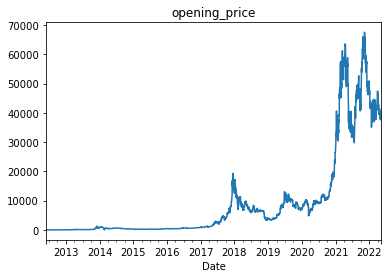

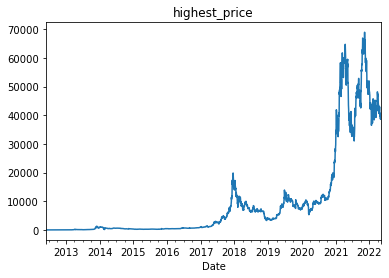

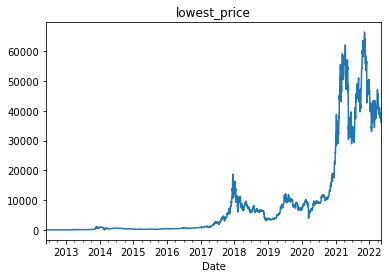

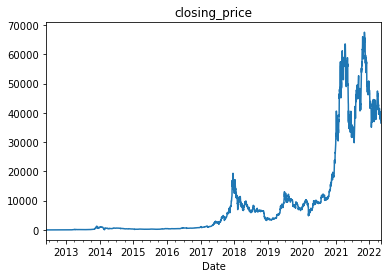

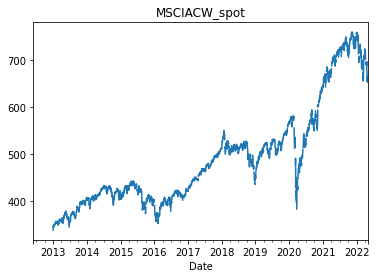

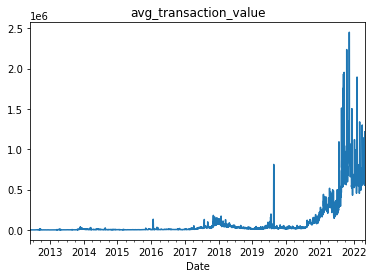

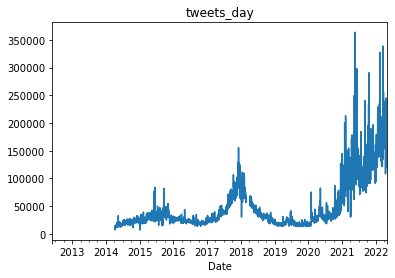

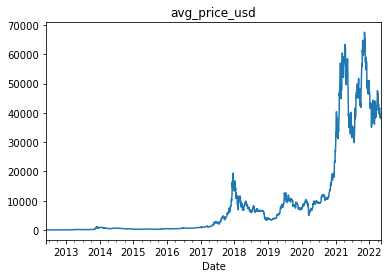

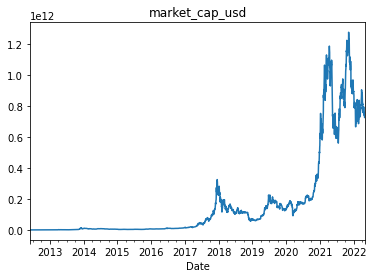

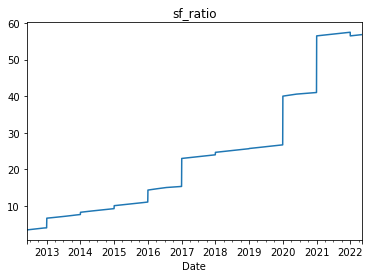

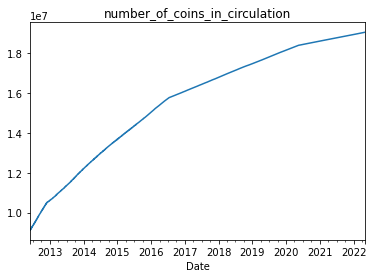

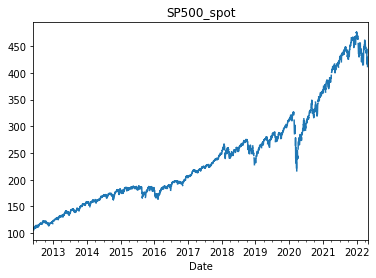

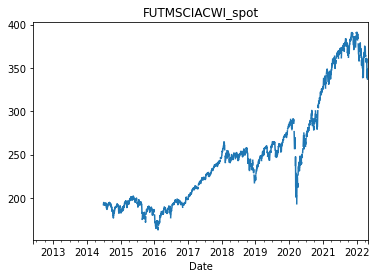

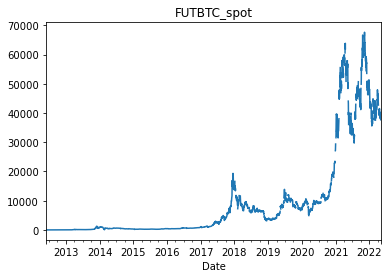

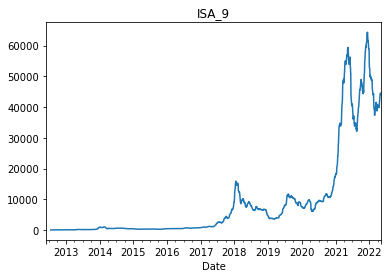

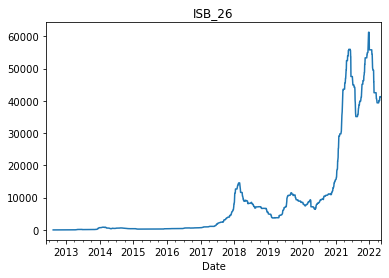

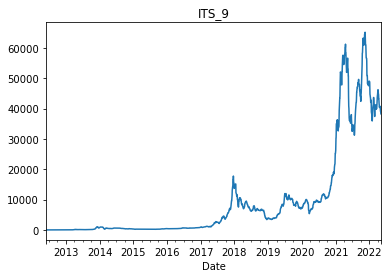

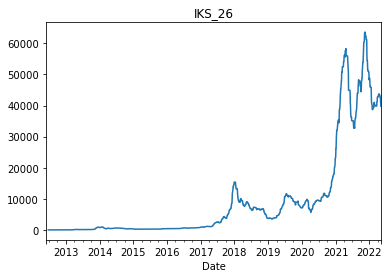

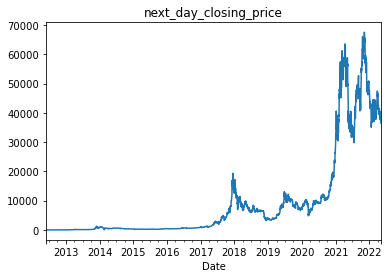

In [33]:
for i, col in enumerate(final_df.columns):
    final_df[col].plot(fig=plt.figure(i))
    plt.title(col)

plt.show()

In [34]:
#lets see the start and end date of the features

final_df.apply(pd.Series.first_valid_index)



opening_price                    2012-06-01
highest_price                    2012-06-01
lowest_price                     2012-06-01
closing_price                    2012-06-01
MSCIACW_spot                     2013-01-01
avg_transaction_value            2012-06-01
tweets_day                       2014-04-09
avg_price_usd                    2012-06-01
market_cap_usd                   2012-06-01
sf_ratio                         2012-06-01
number_of_coins_in_circulation   2012-06-01
SP500_spot                       2012-06-01
FUTMSCIACWI_spot                 2014-06-30
FUTBTC_spot                      2012-06-01
ISA_9                            2012-07-22
ISB_26                           2012-08-17
ITS_9                            2012-06-09
IKS_26                           2012-06-26
next_day_closing_price           2012-06-01
dtype: datetime64[ns]

In [35]:
final_df.apply(pd.Series.last_valid_index)

opening_price                    2022-05-05
highest_price                    2022-05-05
lowest_price                     2022-05-05
closing_price                    2022-05-05
MSCIACW_spot                     2022-05-04
avg_transaction_value            2022-05-05
tweets_day                       2022-05-05
avg_price_usd                    2022-05-05
market_cap_usd                   2022-05-05
sf_ratio                         2022-05-05
number_of_coins_in_circulation   2022-05-05
SP500_spot                       2022-05-04
FUTMSCIACWI_spot                 2022-05-04
FUTBTC_spot                      2022-05-04
ISA_9                            2022-05-05
ISB_26                           2022-05-05
ITS_9                            2022-05-05
IKS_26                           2022-05-05
next_day_closing_price           2022-05-05
dtype: datetime64[ns]

In [36]:
missing_values = pd.DataFrame(final_df.isna().sum(),columns=['missing_count'])
missing_values.sort_values(by='missing_count',ascending=False)

missing_count
FUTMSCIACWI_spot                         1656
MSCIACW_spot                             1189
SP500_spot                               1128
tweets_day                                733
FUTBTC_spot                               497
ISB_26                                     77
ISA_9                                      51
IKS_26                                     25
ITS_9                                       8
opening_price                               0
sf_ratio                                    0
number_of_coins_in_circulation              0
highest_price                               0
market_cap_usd                              0
avg_price_usd                               0
avg_transaction_value                       0
closing_price                               0
lowest_price                                0
next_day_closing_price                      0

Conclussions of missing values:
    - We have info from January 2013 for al variables but for tweets_number and FUTMSCIACWI_spot. (For FUTBTC we didnt have all data but we completed it with closing price as it was considered the best missing data technique for this variable (being a future of bitcoin Price)
    
    - Ichimoku missing variables are all in 2012
    
FUTMSCIACWI_spot	
MSCIACW_spot	
SP500_spot	
FUTBTC_spot

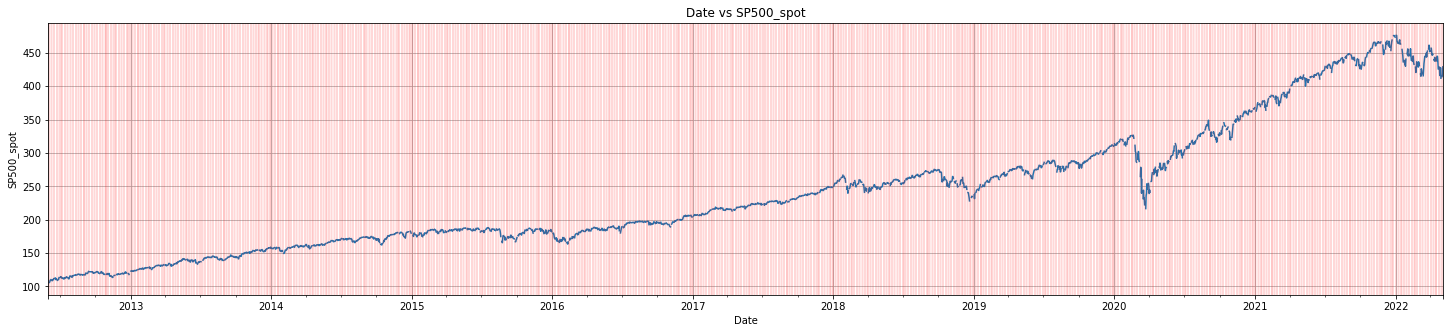

In [37]:
# For quoted values in which weekends and US national holidays are missing we use bfill() so that the last value is remembered
final_df['SP500_spot'].plot(x=final_df.index,y='SP500_spot',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['SP500_spot']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('SP500_spot')
plt.title('Date vs SP500_spot')
plt.show()


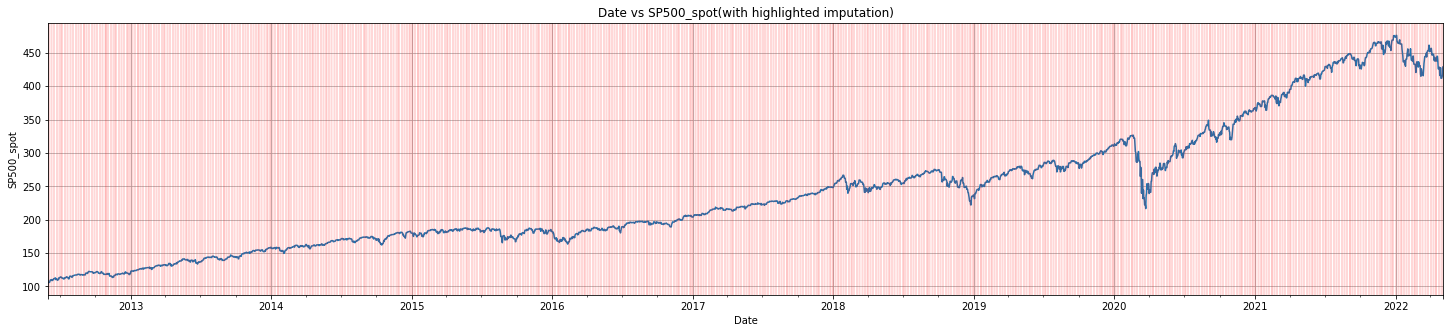

In [38]:
final_df['SP500_spot'].fillna(final_df['SP500_spot'].ffill().astype(float)).plot(x=final_df.index,y='SP500_spot',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['SP500_spot']), :].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('SP500_spot')
plt.title('Date vs SP500_spot(with highlighted imputation)')
plt.show()


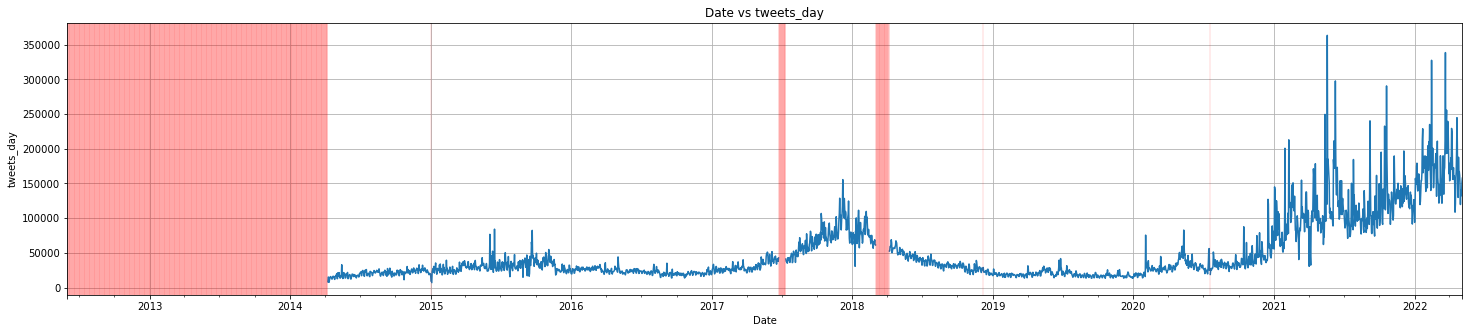

In [39]:
# For other missing values (only twwets days) we will use the rolling average with interpolate so that we take a 7 days window linear filling

final_df['tweets_day'].plot(x=final_df.index,y='tweets_day',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['tweets_day']),:].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('tweets_day')
plt.title('Date vs tweets_day')
plt.show()

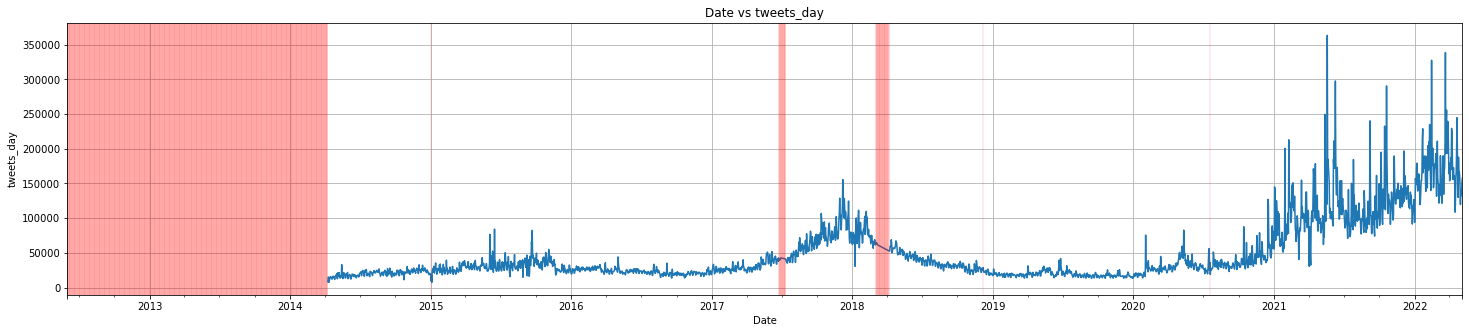

In [40]:
final_df['tweets_day'].fillna(final_df['tweets_day'].rolling(7, min_periods=1).mean().interpolate()).astype(float).plot(x=final_df.index,y='tweets_day',figsize=(25,5),grid=True)
for i in list(final_df.loc[pd.isna(final_df['tweets_day']),:].index):
    plt.axvline(x=i,color='r',alpha=0.1)
plt.ylabel('tweets_day')
plt.title('Date vs tweets_day')
plt.show()


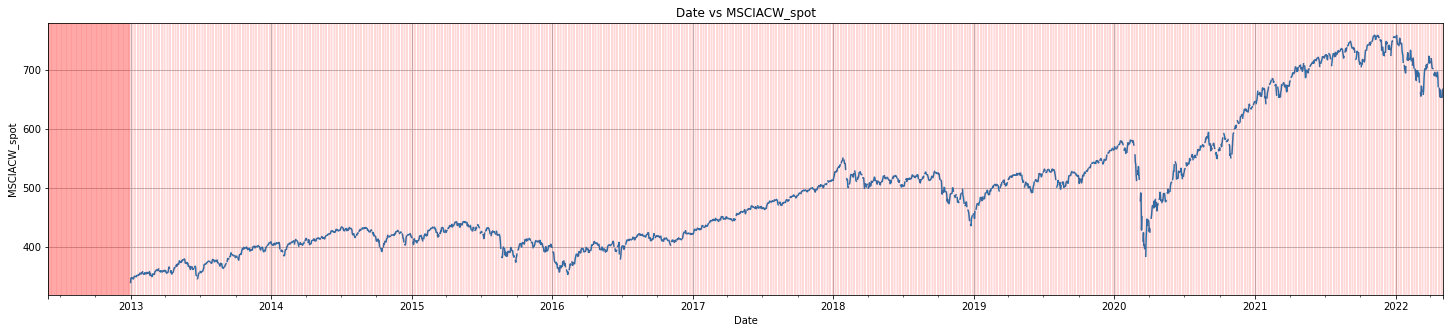

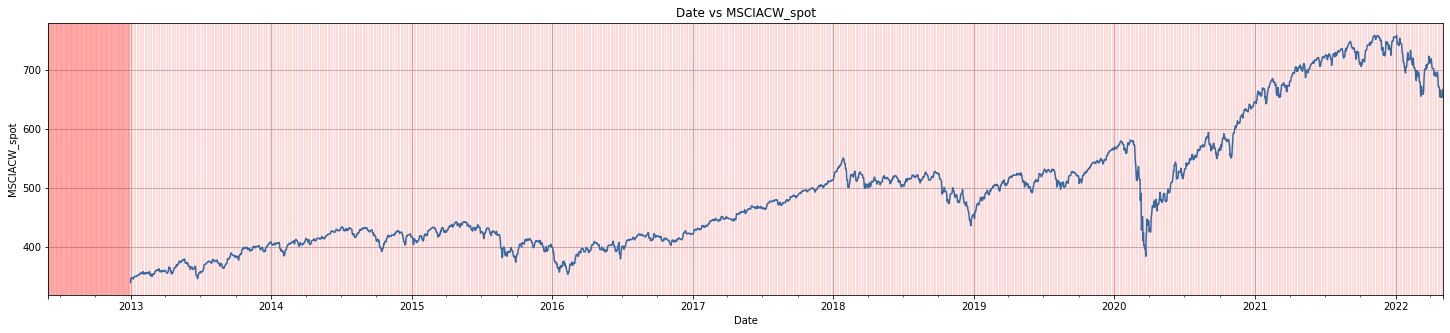

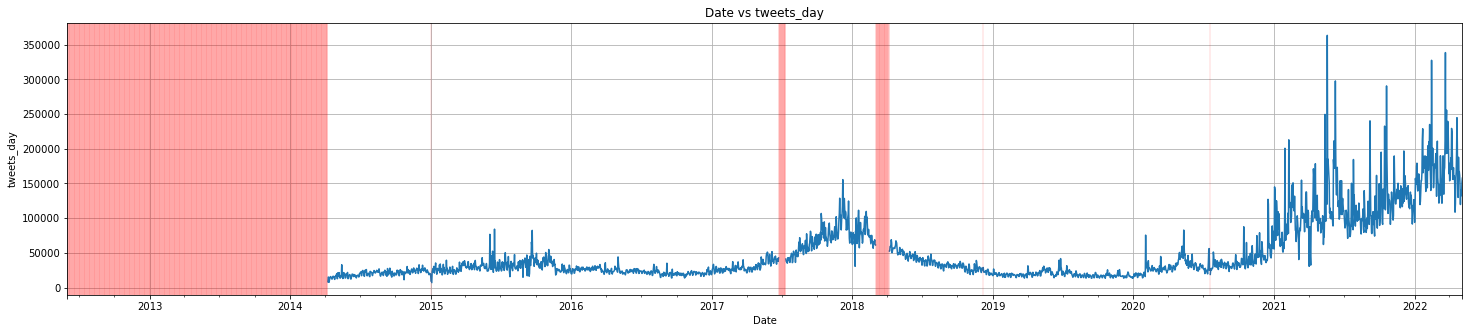

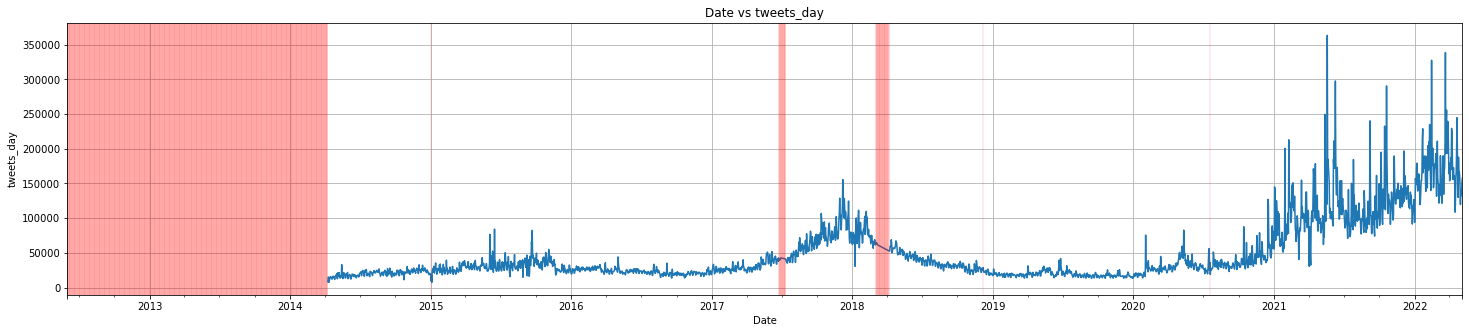

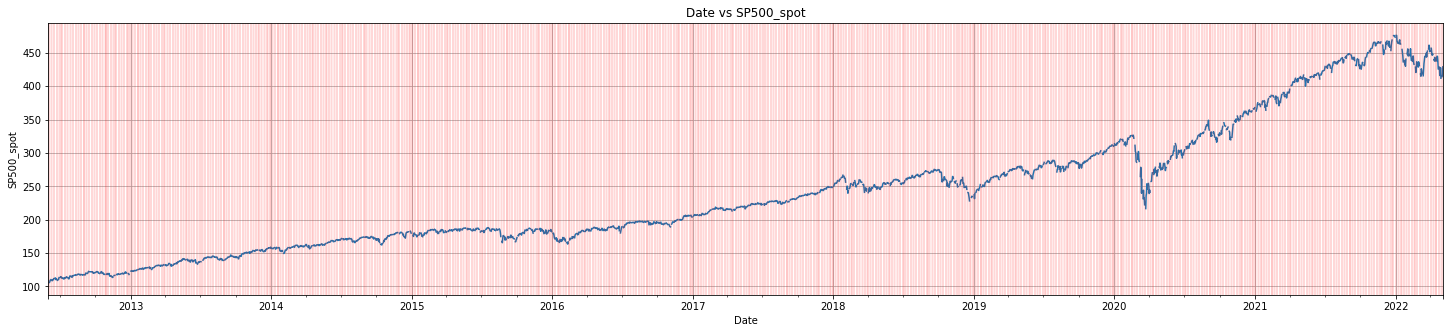

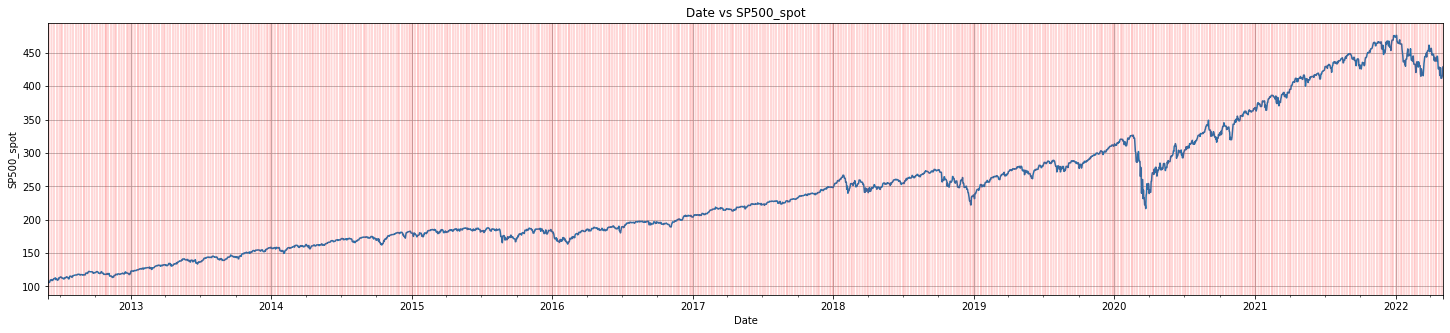

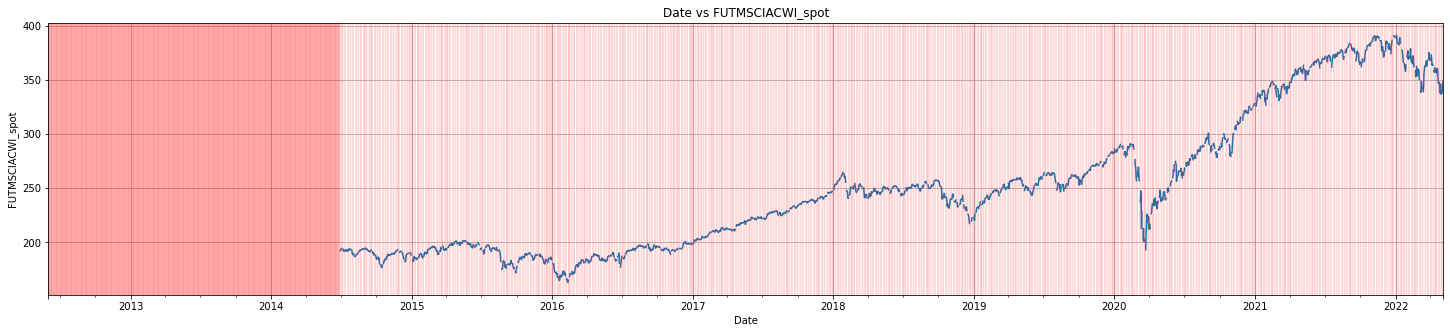

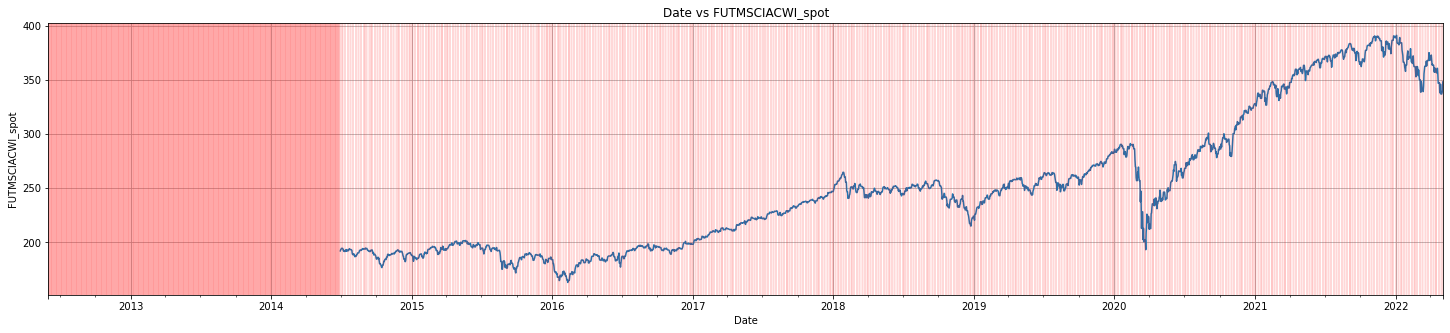

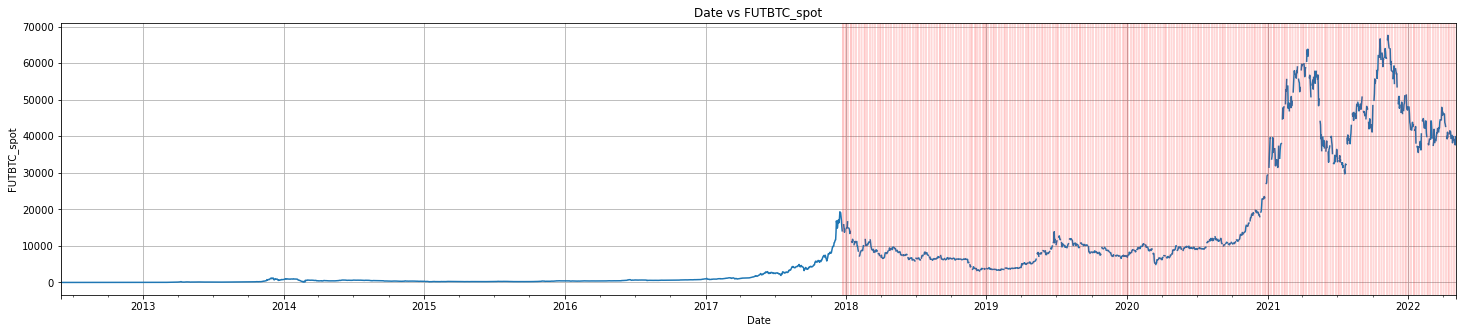

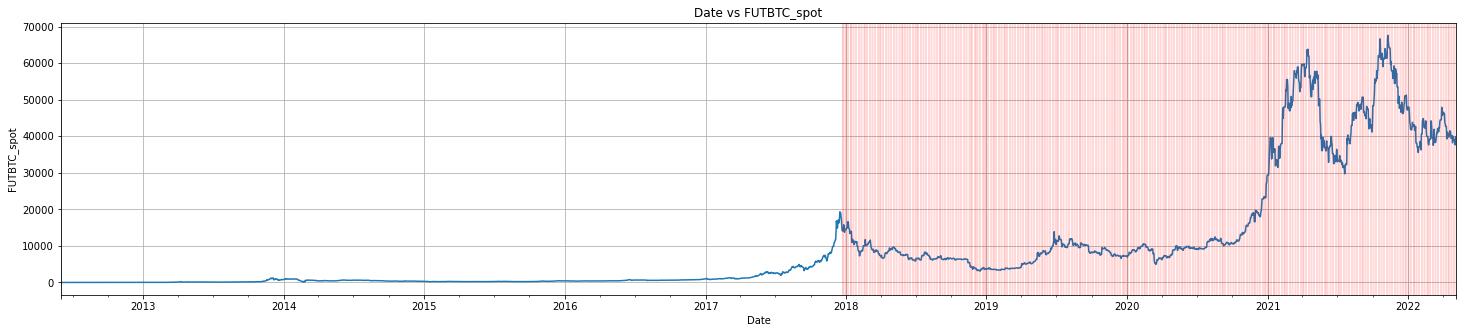

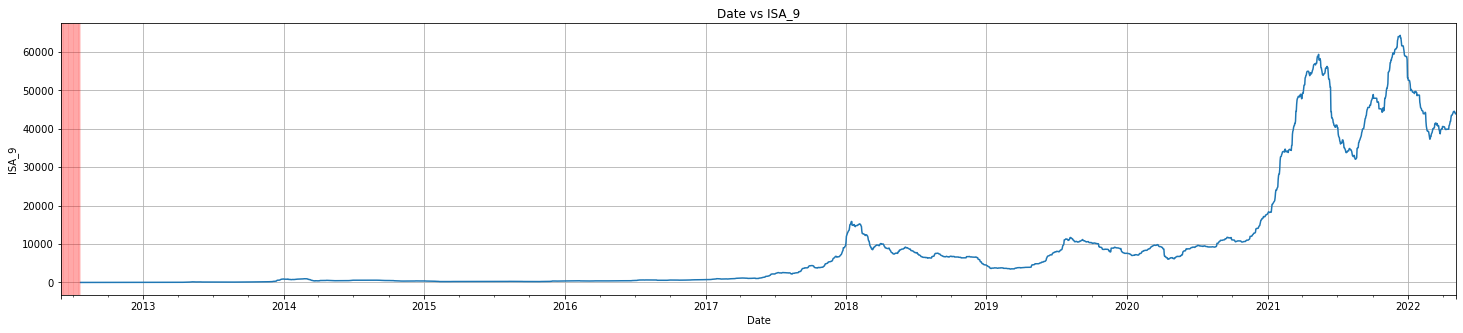

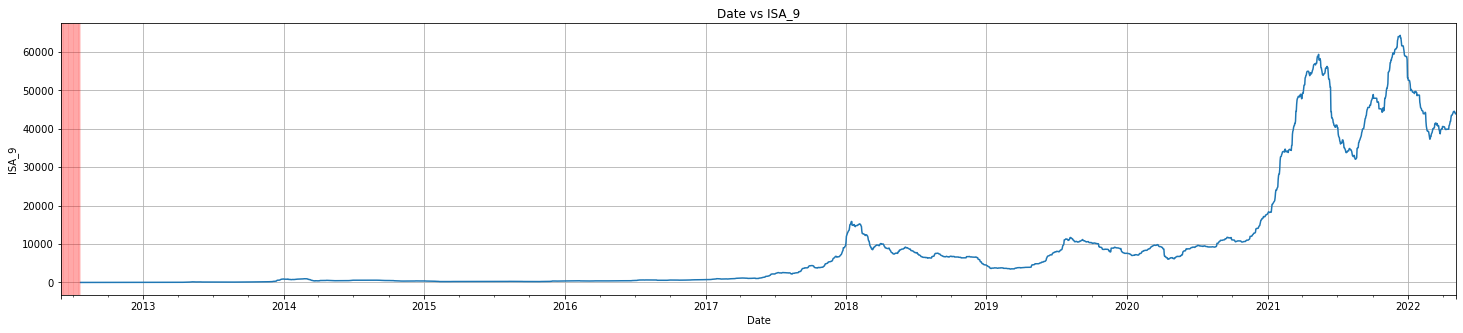

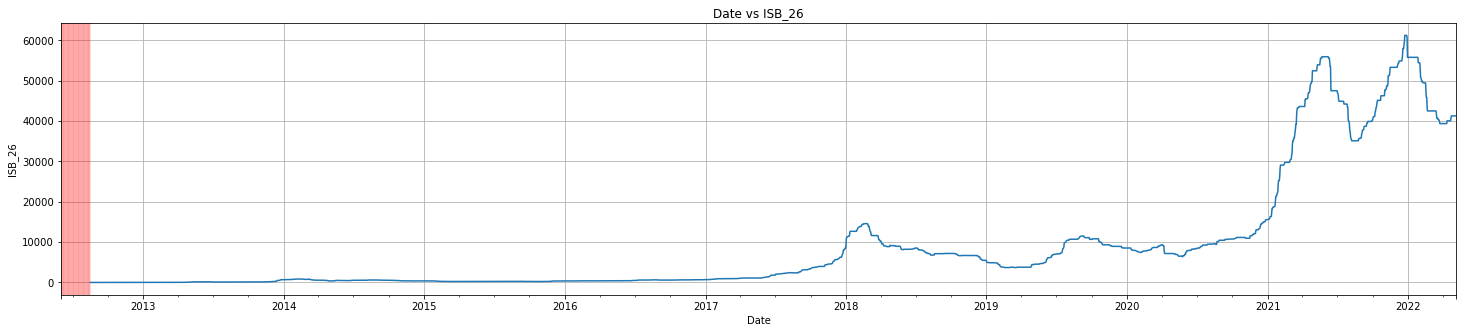

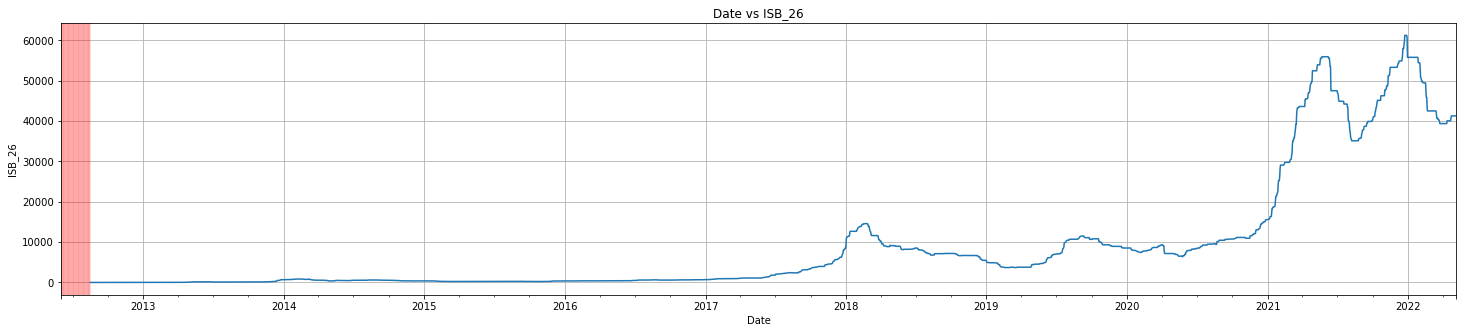

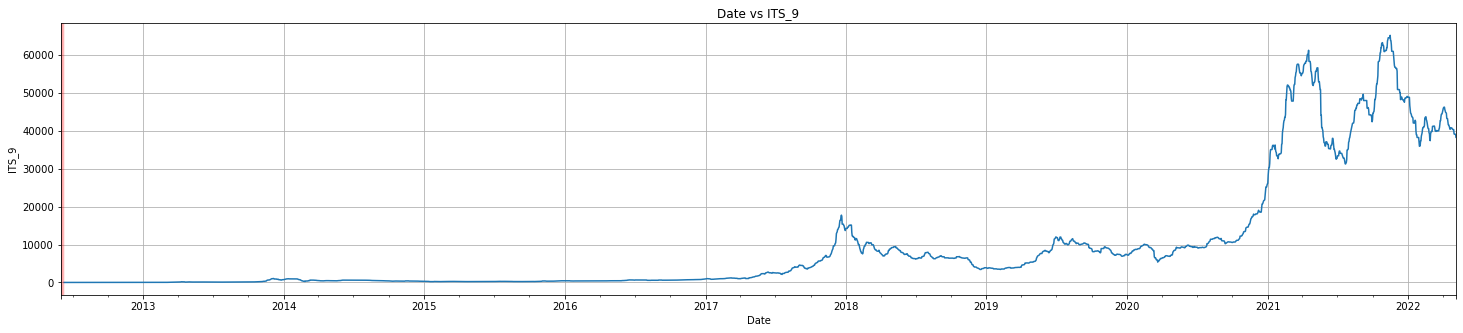

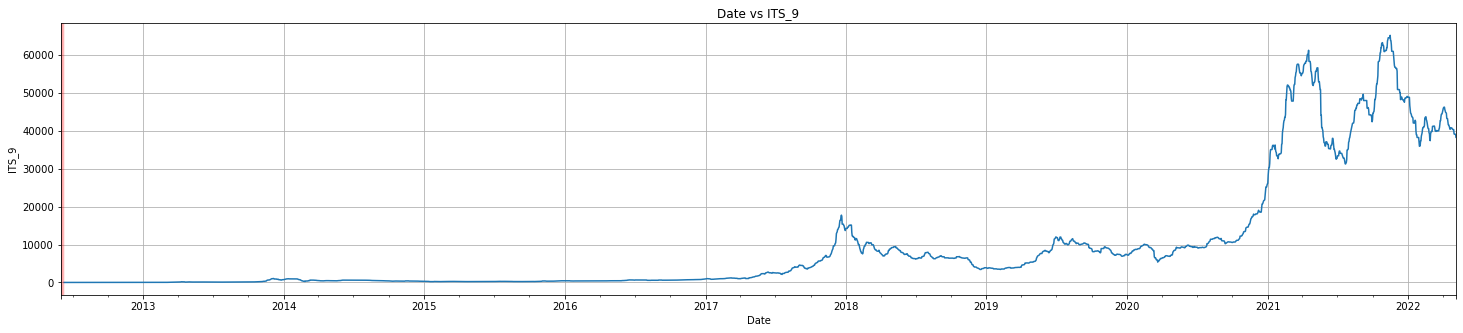

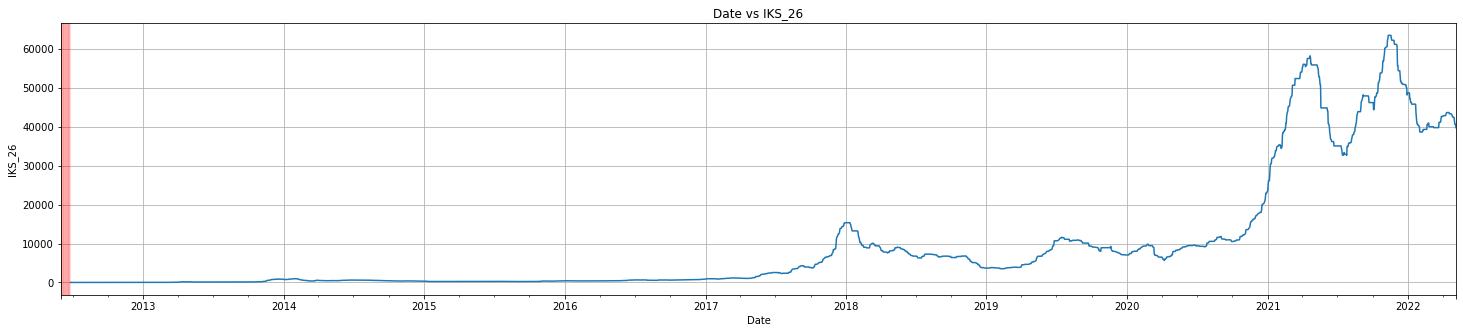

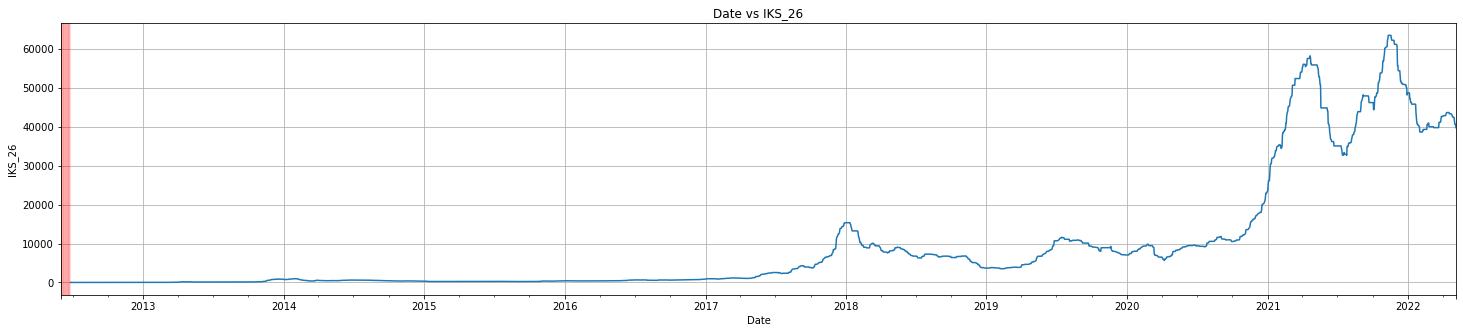

In [41]:
for col in final_df.columns:
    if col in(['FUTMSCIACWI_spot', 'MSCIACW_spot', 'SP500_spot', 'FUTBTC_spot']) : #si es cotizado metemos un backfill, ya que como faltan fiestas queremos que recuerde lo último
        
        final_df[col].plot(x=final_df.index,y=col,figsize=(25,5),grid=True)
        for i in list(final_df.loc[pd.isna(final_df[col]),:].index):
            plt.axvline(x=i,color='r',alpha=0.1)
        plt.ylabel(col)
        plt.title('Date vs ' + col)
        plt.show()
        
        final_df[col].fillna(final_df[col].ffill()).plot(x=final_df.index,y=col,figsize=(25,5),grid=True)
        for i in list(final_df.loc[pd.isna(final_df[col]),:].index):
            plt.axvline(x=i,color='r',alpha=0.1)
        plt.ylabel(col)
        plt.title('Date vs ' + col)
        plt.show()
        
        final_df[col] = final_df[col].fillna(final_df[col].ffill())
    
    elif final_df[col].isna().sum() > 0:    # para el resto interpolamos
        
        final_df[col].plot(x=final_df.index,y=col,figsize=(25,5),grid=True)
        for i in list(final_df.loc[pd.isna(final_df[col]),:].index):
            plt.axvline(x=i,color='r',alpha=0.1)
        plt.ylabel(col)
        plt.title('Date vs ' + col)
        plt.show()
        
        
        final_df[col].fillna(final_df[col].rolling(7, min_periods=1).mean().interpolate()).astype(float).plot(x=final_df.index,y=col,figsize=(25,5),grid=True)
        for i in list(final_df.loc[pd.isna(final_df[col]),:].index):
            plt.axvline(x=i,color='r',alpha=0.1)
        plt.ylabel(col)
        plt.title('Date vs ' + col)
        plt.show()
        
        final_df[col] = final_df[col].fillna(final_df[col].rolling(7, min_periods=1).mean().interpolate())
        
        

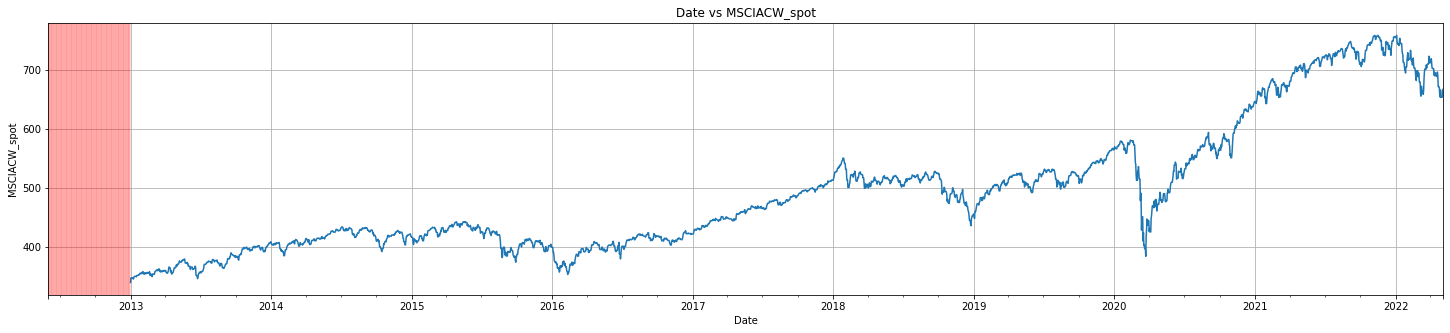

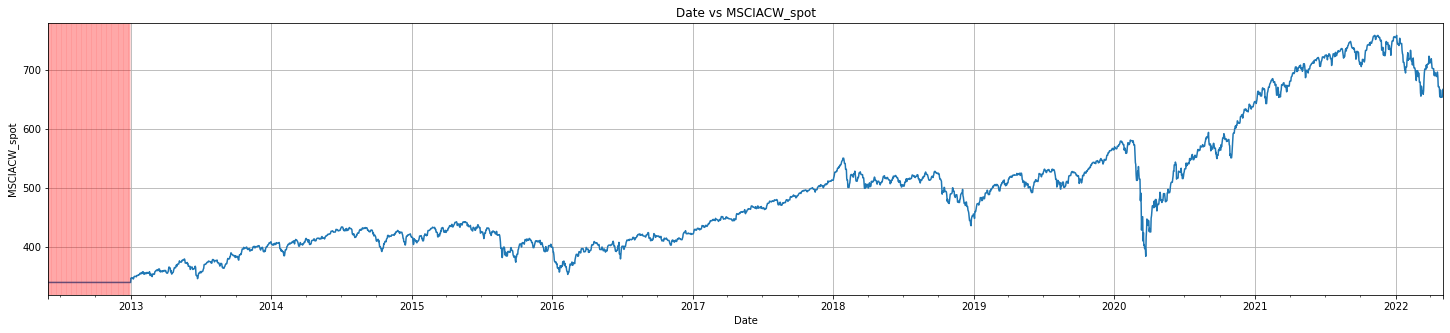

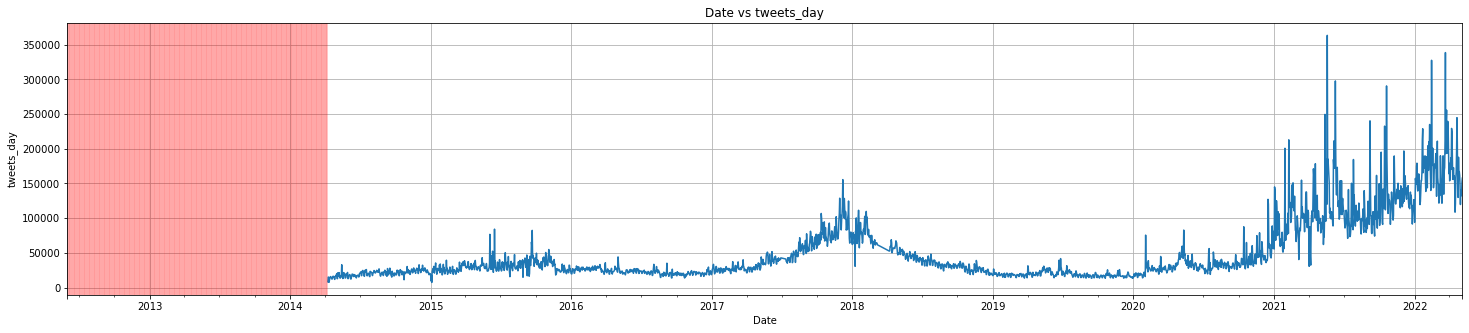

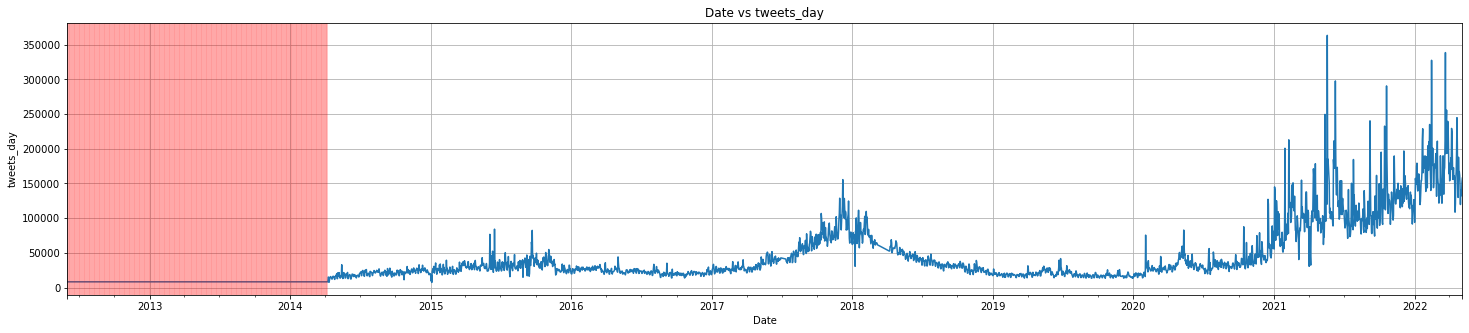

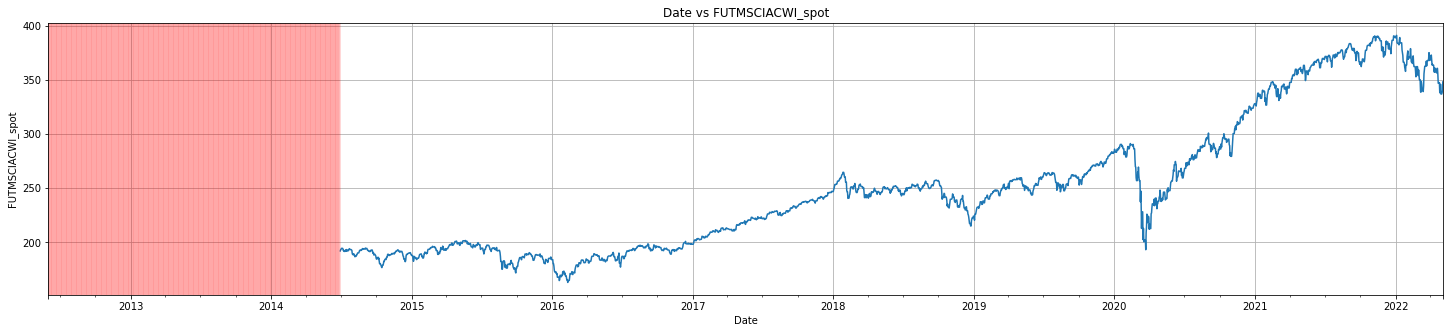

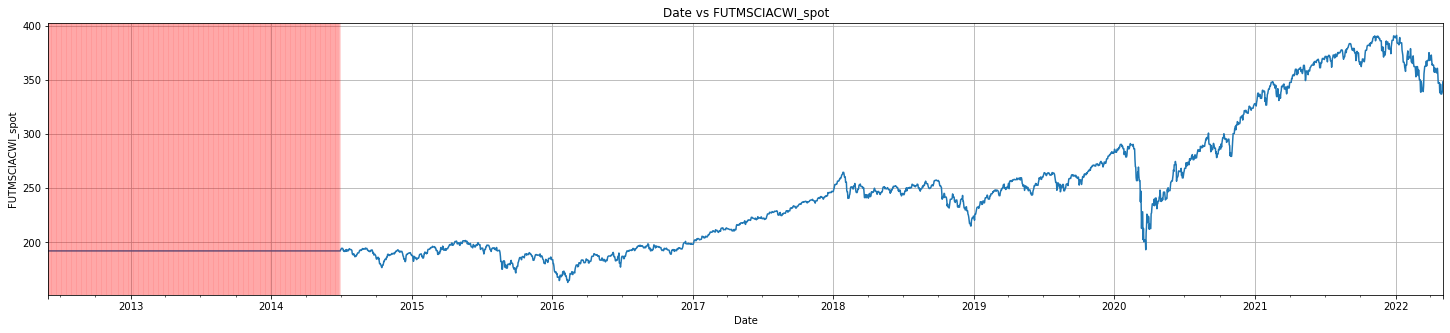

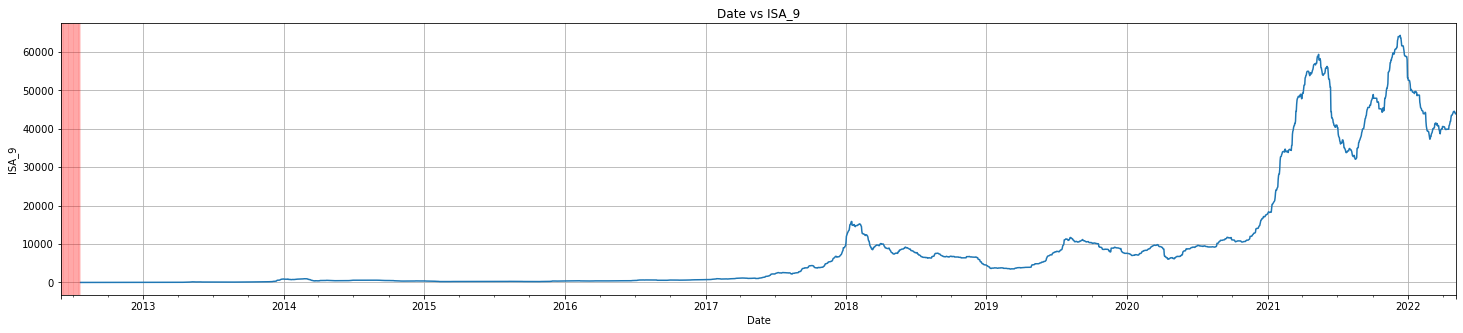

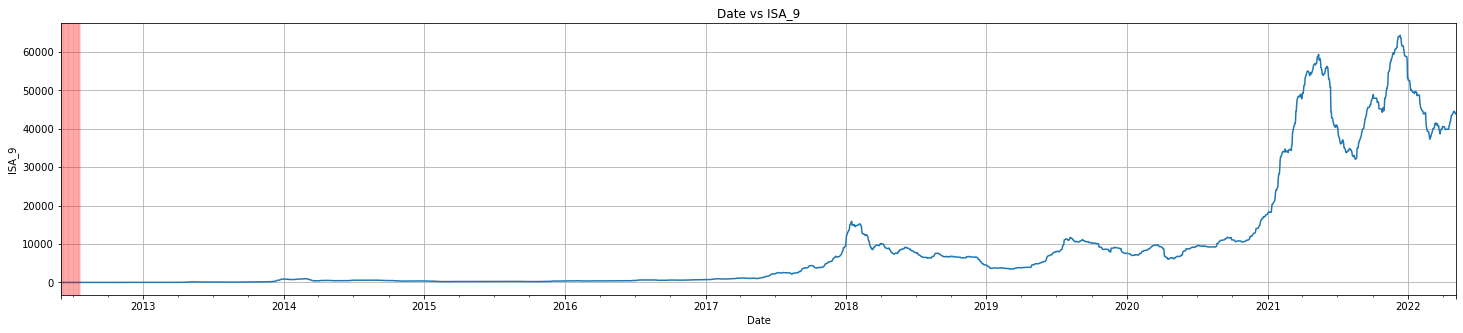

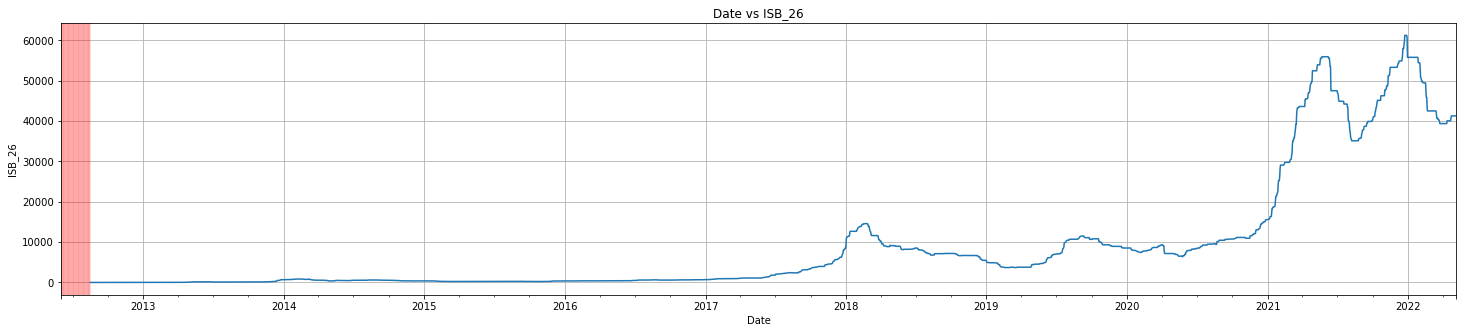

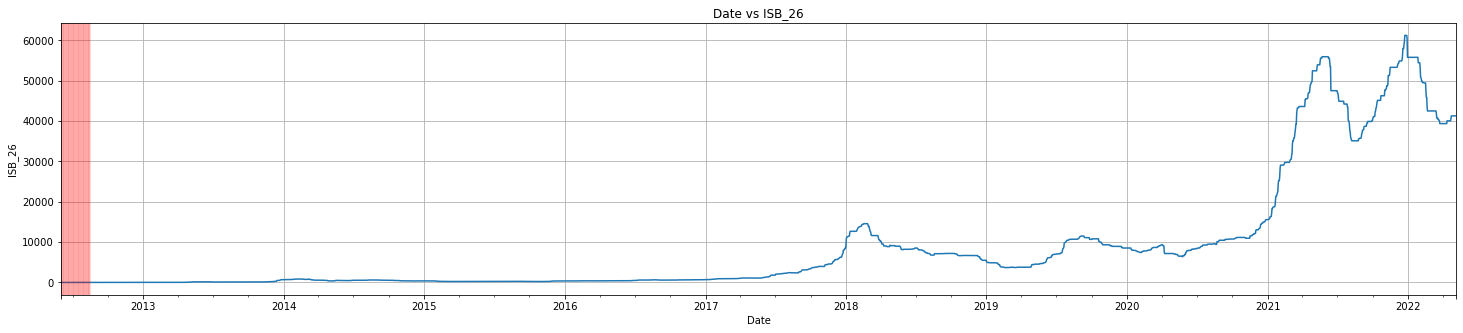

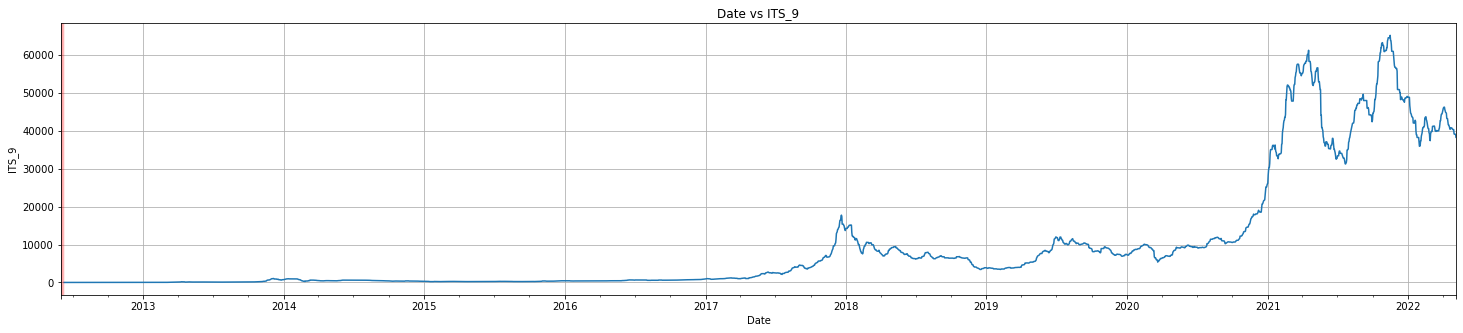

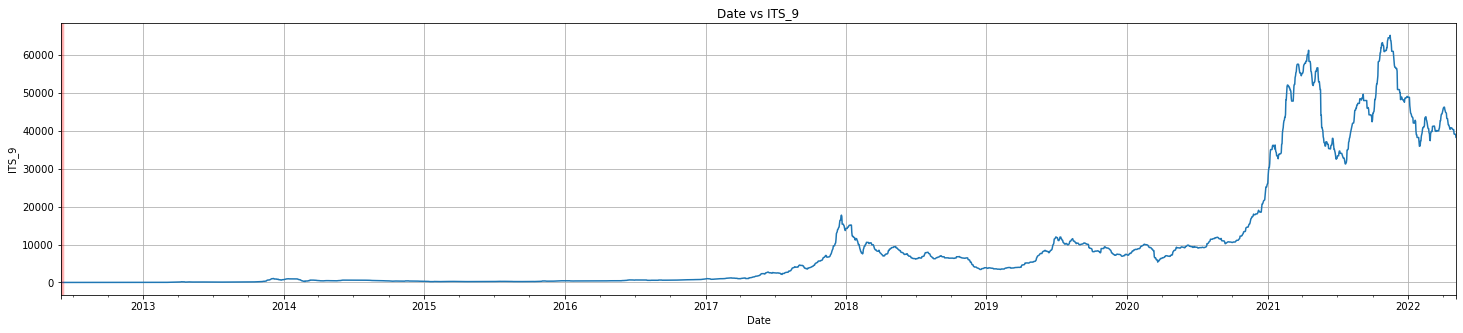

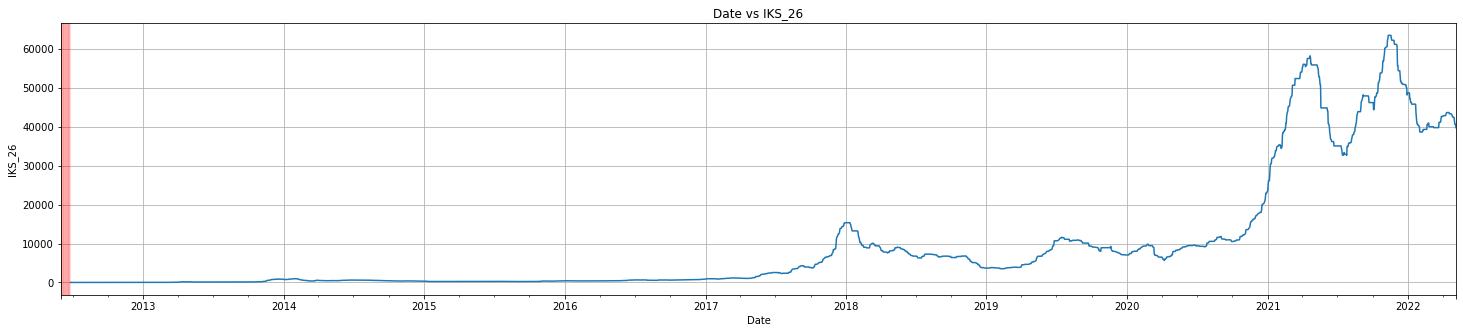

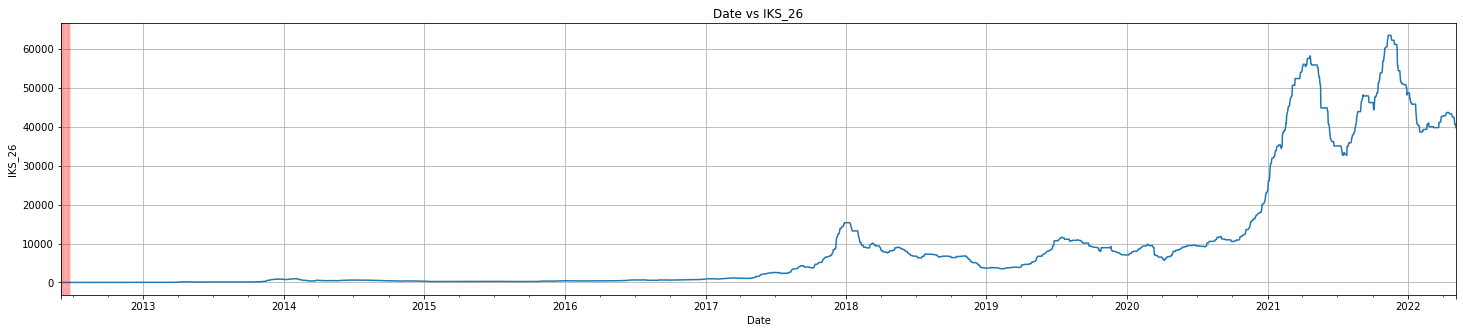

In [42]:
# Le meto otra pasada para completar los missing del principio de la serie backfilling

for col in final_df.columns:
    if final_df[col].isna().sum() > 0: # > 100 so that we take the quoted features in which weekends are missing
        
        final_df[col].plot(x=final_df.index,y=col,figsize=(25,5),grid=True)
        for i in list(final_df.loc[pd.isna(final_df[col]),:].index):
            plt.axvline(x=i,color='r',alpha=0.1)
        plt.ylabel(col)
        plt.title('Date vs ' + col)
        plt.show()
        
        final_df[col].fillna(final_df[col].bfill()).plot(x=final_df.index,y=col,figsize=(25,5),grid=True)
        for i in list(final_df.loc[pd.isna(final_df[col]),:].index):
            plt.axvline(x=i,color='r',alpha=0.1)
        plt.ylabel(col)
        plt.title('Date vs ' + col)
        plt.show()
        
        final_df[col] = final_df[col].fillna(final_df[col].bfill())
    
    
        

In [43]:
missing_values = pd.DataFrame(final_df.isna().sum(),columns=['missing_count'])
missing_values.sort_values(by='missing_count',ascending=False)

missing_count
opening_price                               0
number_of_coins_in_circulation              0
IKS_26                                      0
ITS_9                                       0
ISB_26                                      0
ISA_9                                       0
FUTBTC_spot                                 0
FUTMSCIACWI_spot                            0
SP500_spot                                  0
sf_ratio                                    0
highest_price                               0
market_cap_usd                              0
avg_price_usd                               0
tweets_day                                  0
avg_transaction_value                       0
MSCIACW_spot                                0
closing_price                               0
lowest_price                                0
next_day_closing_price                      0

# Feature engineering: Cálculo de indicadores técnicos

In [44]:
feature_list = [i for i in list(final_df.columns) if i not in ['Date','next_day_closing_price','ISA_9','ISB_26','ITS_9','IKS_26']]

for feature in feature_list:
    feature_calculus(final_df,feature,'sma')
    feature_calculus(final_df,feature,'wma')
    feature_calculus(final_df,feature,'ema')
    feature_calculus(final_df,feature,'dema')
    feature_calculus(final_df,feature,'tema')
    feature_calculus(final_df,feature,'stdev')
    feature_calculus(final_df,feature,'var')
    feature_calculus(final_df,feature,'rsi')
    feature_calculus(final_df,feature,'roc')
    feature_calculus(final_df,feature,'bband_lower')
    feature_calculus(final_df,feature,'bband_upper')
    feature_calculus(final_df,feature,'macd')

In [45]:
final_df

opening_price  highest_price  lowest_price  closing_price  \
Date                                                                    
2012-06-01            5.2            5.3           5.2            5.3   
2012-06-02            5.3            5.3           5.2            5.3   
2012-06-03            5.3            5.3           5.2            5.2   
2012-06-04            5.2            5.3           5.2            5.3   
2012-06-05            5.3            5.5           5.2            5.4   
...                   ...            ...           ...            ...   
2022-05-01        37642.0        38676.0       37397.0        38461.0   
2022-05-02        38472.0        39134.0       38061.0        38514.0   
2022-05-03        38515.0        38647.0       37513.0        37718.0   
2022-05-04        37717.0        40021.0       37660.0        39688.0   
2022-05-05        39686.0        39833.0       36183.0        36544.0   

            MSCIACW_spot  avg_transaction_value  tweets_day  avg_price_usd  \
Date                                                                         
2012-06-01        339.78                573.098      8193.0          5.237   
2012-06-02        339.78                815.262      8193.0          5.262   
2012-06-03        339.78                268.139      8193.0          5.227   
2012-06-04        339.78                529.294      8193.0          5.243   
2012-06-05        339.78                546.275      8193.0          5.353   
...                  ...                    ...         ...            ...   
2022-05-01        653.67             658314.000    140890.0      38058.000   
2022-05-02        653.57             905913.000    140078.0      38684.000   
2022-05-03        656.13            1213754.000    132370.0      38264.000   
2022-05-04        667.08            1044679.000    151707.0      38809.000   
2022-05-05        667.08            1214640.000    157763.0      38452.000   

            market_cap_usd   sf_ratio  ...  FUTBTC_spot bband_upper5  \
Date                                   ...                             
2012-06-01    4.777294e+07   3.487664  ...                       NaN   
2012-06-02    4.803631e+07   3.490680  ...                       NaN   
2012-06-03    4.775541e+07   3.488523  ...                       NaN   
2012-06-04    4.794578e+07   3.496158  ...                       NaN   
2012-06-05    4.899278e+07   3.499384  ...                  5.426491   
...                    ...        ...  ...                       ...   
2022-05-01    7.241622e+11  56.790461  ...              39923.739661   
2022-05-02    7.361124e+11  56.793726  ...              39920.000000   
2022-05-03    7.281503e+11  56.796337  ...              39814.681250   
2022-05-04    7.385454e+11  56.798949  ...              40355.479108   
2022-05-05    7.317932e+11  56.802213  ...              40746.360753   

            FUTBTC_spot bband_upper7  FUTBTC_spot bband_upper10  \
Date                                                              
2012-06-01                       NaN                        NaN   
2012-06-02                       NaN                        NaN   
2012-06-03                       NaN                        NaN   
2012-06-04                       NaN                        NaN   
2012-06-05                       NaN                        NaN   
...                              ...                        ...   
2022-05-01              40421.506998               40332.213052   
2022-05-02              39919.035584               40288.432629   
2022-05-03              40157.075649               40445.484176   
2022-05-04              40475.945988               40566.341411   
2022-05-05              40466.211090               40450.201733   

            FUTBTC_spot bband_upper15  FUTBTC_spot bband_upper30  \
Date                                                               
2012-06-01                        NaN                        NaN   
2012-06-02                        

# Feature selection

In [46]:
for x in ['ISA_9','ISB_26','ITS_9','IKS_26']: # we put back the ichimoku features in the list so we have a list with all variables without engineering
    feature_list.append(x)

In [47]:
feature_list

['opening_price',
 'highest_price',
 'lowest_price',
 'closing_price',
 'MSCIACW_spot',
 'avg_transaction_value',
 'tweets_day',
 'avg_price_usd',
 'market_cap_usd',
 'sf_ratio',
 'number_of_coins_in_circulation',
 'SP500_spot',
 'FUTMSCIACWI_spot',
 'FUTBTC_spot',
 'ISA_9',
 'ISB_26',
 'ITS_9',
 'IKS_26']

In [48]:
# Data range selection
final_df.reset_index(inplace=True)
final_df_selection = final_df.loc[final_df['Date'] >= first_date_selection].copy()

In [49]:
for x in tqdm(feature_list):   # Nos creamos un DF por cada vaiable principal
    
    globals()[str(x)+"_df"] = final_df_selection[[x,'next_day_closing_price']]
    final_df_selection.drop([x],inplace=True,axis=1)
    for y in final_df_selection.columns:
        if x.split(" ")[0] == y.split(" ")[0]:
            globals()[str(x)+"_df"][y] = final_df_selection[y]
            final_df_selection.drop([y],inplace=True,axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:06<00:00,  2.78it/s]


In [50]:
# Cogemos las 2 principlaes variables que no esten correlacionadas entre ellas en mas de 0.9

for x in tqdm(feature_list):
    if x!='next_day_closing_price':

        for y in feature_selector(globals()[(str(x)+"_df")], 'next_day_closing_price', 0,0.9)[0:2]:
            final_df_selection[y] =  globals()[(str(x)+"_df")][y]

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:17<00:00,  1.02it/s]


In [51]:
pd. set_option('display.max_columns', 500)
final_df_selection[final_df_selection.isna().any(axis=1)]


Empty DataFrame
Columns: [Date, next_day_closing_price, opening_price, opening_price stdev60, highest_price, highest_price stdev60, lowest_price, lowest_price stdev60, closing_price, closing_price stdev60, MSCIACW_spot dema90, MSCIACW_spot stdev15, avg_transaction_value tema90, avg_transaction_value bband_lower5, tweets_day stdev90, tweets_day ema3, avg_price_usd, avg_price_usd stdev60, market_cap_usd, market_cap_usd stdev60, sf_ratio sma 60, sf_ratio rsi60, number_of_coins_in_circulation stdev90, number_of_coins_in_circulation stdev3, SP500_spot bband_lower7, SP500_spot stdev90, FUTMSCIACWI_spot ema60, FUTMSCIACWI_spot stdev15, FUTBTC_spot tema3, FUTBTC_spot stdev60, ISA_9, ISB_26, ITS_9, IKS_26]
Index: []

In [52]:
final_df_selection=final_df_selection.dropna(axis=1)

In [53]:
# Data Scaling
X = final_df_selection.drop(['Date','next_day_closing_price'],axis=1)

scaler = RobustScaler()
X_scaled = X.copy()
X_scaled[X.columns] = scaler.fit_transform(X[X.columns])

scaler = MinMaxScaler()
X_scaled[X.columns] =  scaler.fit_transform(X_scaled[X.columns])


In [54]:
#X_scaled.columns.to_series()[np.isnan(X_scaled).any()]


In [55]:
y = final_df_selection['next_day_closing_price']
rf = RandomForestRegressor(n_estimators=2000,n_jobs=-1,bootstrap=True,
                           verbose=1,random_state=42)
rf.fit(X_scaled,y)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   11.6s finished


RandomForestRegressor(n_estimators=2000, n_jobs=-1, random_state=42, verbose=1)

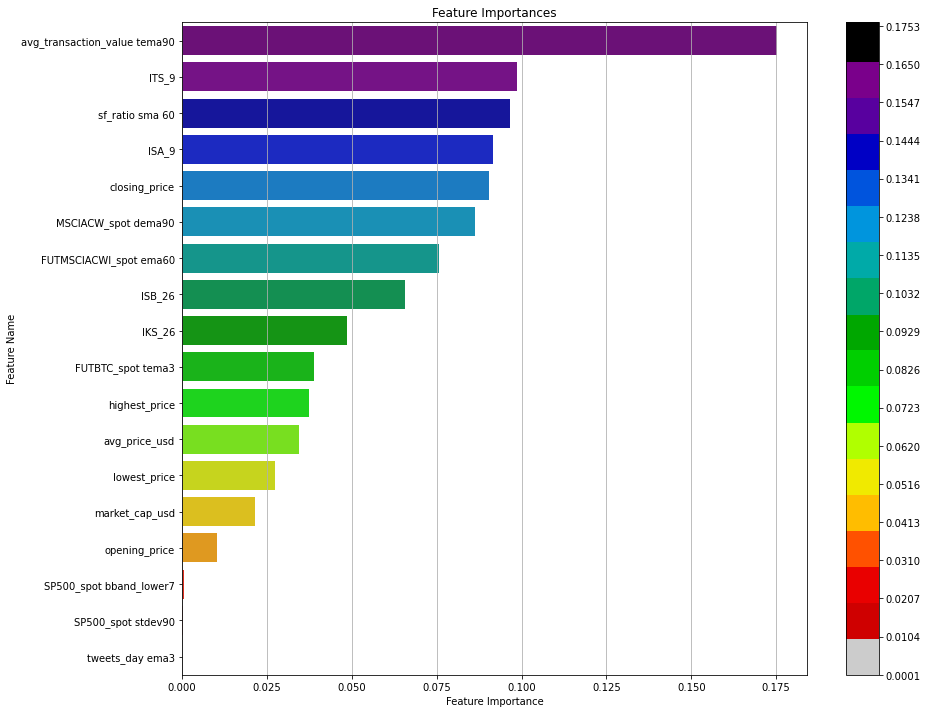

In [56]:
feat_imp_df,final_df_selection_final = feature_imp(X_scaled,rf.feature_importances_,n_features)
final_df_selection_final.insert(loc=0, column='Date', value=final_df_selection['Date'])
final_df_selection_final['next_day_closing_price'] = final_df_selection['next_day_closing_price']

In [57]:
final_df_selection_final

Date  avg_transaction_value tema90         ITS_9  sf_ratio sma 60  \
214  2013-01-01                      0.000000  0.000000e+00         0.000000   
215  2013-01-02                      0.000010  0.000000e+00         0.000862   
216  2013-01-03                      0.000013  7.673949e-07         0.001723   
217  2013-01-04                      0.000022  7.673949e-07         0.002584   
218  2013-01-05                      0.000034  7.673949e-07         0.003445   
219  2013-01-06                      0.000031  7.673949e-07         0.004306   
220  2013-01-07                      0.000031  0.000000e+00         0.005167   
221  2013-01-08                      0.000046  2.302185e-06         0.006028   
222  2013-01-09                      0.000049  2.302185e-06         0.006887   
223  2013-01-10                      0.000041  5.371764e-06         0.007747   
224  2013-01-11                      0.000033  6.906554e-06         0.008606   
225  2013-01-12                      0.000023  6.906554e-06         0.009466   
226  2013-01-13                      0.000011  6.906554e-06         0.010326   
227  2013-01-14                      0.000005  7.673949e-06         0.011185   
228  2013-01-15                      0.000018  8.441344e-06         0.012044   
229  2013-01-16                      0.000027  1.074353e-05         0.012903   
230  2013-01-17                      0.000034  1.918487e-05         0.013762   
231  2013-01-18                      0.000038  2.302185e-05         0.014620   
232  2013-01-19                      0.000036  2.378924e-05         0.015478   
233  2013-01-20                      0.000036  2.378924e-05         0.016336   
234  2013-01-21                      0.000037  3.146319e-05         0.017194   
235  2013-01-22                      0.000044  3.683496e-05         0.018052   
236  2013-01-23                      0.000070  3.683496e-05         0.018909   
237  2013-01-24                      0.000079  5.064807e-05         0.019766   
238  2013-01-25                      0.000084  5.371764e-05         0.020624   
239  2013-01-26                      0.000083  5.908941e-05         0.021479   
240  2013-01-27                      0.000083  5.908941e-05         0.022336   
241  2013-01-28                      0.000090  5.985680e-05         0.023194   
242  2013-01-29                      0.000115  6.446117e-05         0.024050   
243  2013-01-30                      0.000161  6.446117e-05         0.024908   
244  2013-01-31                      0.000167  7.673949e-05         0.025767   
245  2013-02-01                      0.000174  7.673949e-05         0.026624   
246  2013-02-02                      0.000174  7.673949e-05         0.027483   
247  2013-02-03                      0.000171  8.518084e-05         0.028342   
248  2013-02-04                      0.000185  9.055260e-05         0.029202   
249  2013-02-05                      0.000200  9.515697e-05         0.030063   
250  2013-02-06                      0.000222  9.669176e-05         0.030923   
251  2013-02-07                      0.000226  1.028309e-04         0.031784   
252  2013-02-08                      0.000242  1.074353e-04         0.032646   
253  2013-02-09                      0.000252  1.166440e-04         0.033507   
254  2013-02-10                      0.000253  1.174114e-04         0.034369   
255  2013-02-11                      0.000253  1.327593e-04         0.035232   
256  2013-02-12                      0.000252  1.450376e-04         0.036094   
257  2013-02-13                      0.000250  1.511768e-04         0.036958   
258  2013-02-14                      0.000262  1.642225e-04         0.037822   
259  2013-02-15                      0.000266  1.657573e-04         0.038685   
260  2013-02-16                      0.000272  1.726639e-04         0.039550   
261  2013-02-17                      0.000276  1.726639e-04         0.040416   
262  2013-02-18                      0.000281  1.726639e-04         0.041280   
263  2013-0

### Train Test Split

In [58]:
train_window = size_training_windows
test_window = size_test_windows
train_splits = []
test_splits = []
for i in tqdm(range(train_window, len(final_df_selection_final),test_window)):
    train_split = final_df_selection_final[i-train_window:i]
    test_split = final_df_selection_final[i:i+test_window]
    train_splits.append(train_split)
    test_splits.append(test_split)

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 30102.66it/s]


# LINEAR REGRESSION NORMAL

In [59]:
lr_date_array = []
lr_y_test_array = []
lr_y_test_pred_array = []
lr_batch_id_array = []
lr_batch_id_array_result = []
lr_batch_mae_train_array = []
lr_batch_rmse_train_array = []
lr_batch_mae_test_array = []
lr_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    lin_reg = LinearRegression()
    lin_reg.fit(Xtrain_split, ytrain_split)


    ytrain_pred = lin_reg.predict(Xtrain_split)
    ytest_pred = lin_reg.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    lr_date_array.extend(test_splits[i]['Date'])
    lr_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    lr_y_test_pred_array.extend((ytest_pred.flatten()))
    lr_batch_id_array.extend([i]*len(test_splits[i]))

    lr_batch_id_array_result.append(i)
    lr_batch_mae_train_array.append(MAE_train)
    lr_batch_rmse_train_array.append(RMSE_train)
    lr_batch_mae_test_array.append(MAE_test)
    lr_batch_rmse_test_array.append(RMSE_test)

lr_result_test_df = pd.DataFrame()
lr_result_test_df['batch_id'] = lr_batch_id_array
lr_result_test_df['Date'] = lr_date_array
lr_result_test_df['y_test'] = lr_y_test_array
lr_result_test_df['y_test_pred'] = lr_y_test_pred_array
lr_y_test_array = lr_result_test_df['y_test']
lr_y_test_pred_array = lr_result_test_df['y_test_pred']

lr_result_metrics_df = pd.DataFrame()
lr_result_metrics_df['batch_id'] = lr_batch_id_array_result
lr_result_metrics_df['mae_train'] = lr_batch_mae_train_array
lr_result_metrics_df['rmse_train'] = lr_batch_rmse_train_array
lr_result_metrics_df['mae_test'] = lr_batch_mae_test_array
lr_result_metrics_df['rmse_test'] = lr_batch_rmse_test_array

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 156.77it/s]


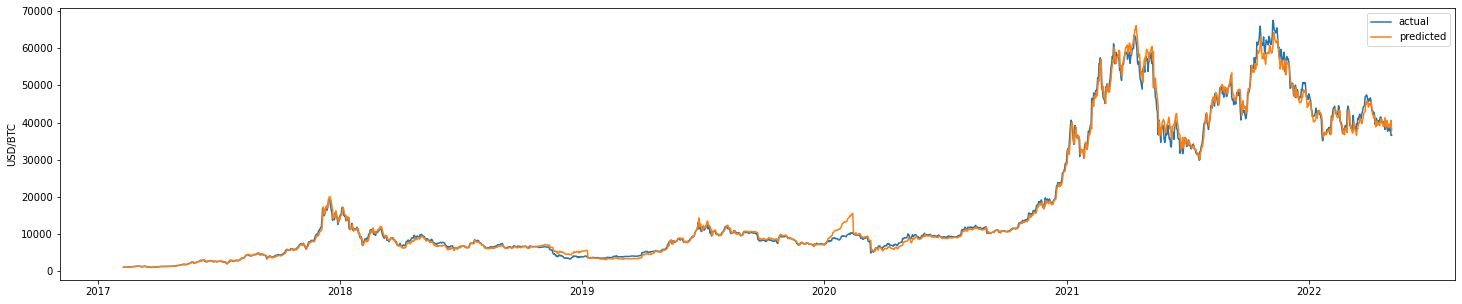

In [60]:
plt.figure(figsize=(25,5))
plt.plot(lr_date_array[1000:],lr_y_test_array[1000:],label='actual')
plt.plot(lr_date_array[1000:],lr_y_test_pred_array[1000:],label='predicted')
plt.legend()
plt.ylabel('USD/BTC')
plt.show()

In [61]:
lr_result_metrics_df

batch_id    mae_train   rmse_train     mae_test    rmse_test
0          0    20.372485    41.333564    16.338394    21.164430
1          1    21.094574    41.809670    18.550895    22.087423
2          2    21.520368    41.937823    14.441023    19.470729
3          3    22.273156    42.208020    16.324745    19.250014
4          4    13.114550    27.142421    21.499968    27.925923
5          5     7.373263    11.069317    15.449456    19.467088
6          6     6.644109    10.260350     6.810726    10.592313
7          7     6.031467     9.612803    12.721879    20.816085
8          8     6.884374    11.846751     7.446977    13.971665
9          9     7.509357    13.018635    19.866351    32.975491
10        10    10.383365    18.380487    35.158322    48.285004
11        11    14.301077    25.463663   116.898548   149.196164
12        12    35.901016    63.943849   311.381705   455.747120
13        13    76.459850   150.339992   761.788548   997.554708
14        14   210.936824   393.838778   523.563068   610.607970
15        15   250.238143   415.869397   239.969871   292.750205
16        16   271.833721   426.037650   772.179851   926.894964
17        17   272.493121   429.506150   465.074524   516.921716
18        18   246.605032   394.060801   404.112196   621.345139
19        19   176.748661   275.687752   374.489687   456.210195
20        20   174.331054   280.754753  1217.966219  2005.637701
21        21   177.357309   283.139277   663.851825   826.662617
22        22   206.104389   335.217807   375.503113   435.954579
23        23   225.844982   349.277865   418.676669   602.000304
24        24   215.059701   342.600006  1543.012389  2071.893165
25        25   458.116916   842.100334  2502.684147  3070.295154
26        26   755.309313  1267.331897  1283.129431  1677.095076
27        27   932.717744  1423.651367  2170.339616  2611.077074
28        28  1147.736067  1619.895937  1226.447674  1657.672682
29        29  1272.099219  1709.920602  1441.276198  1849.981834

In [62]:
pd.DataFrame(lr_result_metrics_df.mean()).drop(['batch_id'],axis=0)

0
mae_train   242.113174
rmse_train  376.575257
mae_test    566.565134
rmse_test   736.383484

In [63]:
pd.DataFrame(lr_result_metrics_df[20:].mean()).drop(['batch_id'],axis=0)

0
mae_train    556.467670
rmse_train   845.388984
mae_test    1284.288728
rmse_test   1680.827019

In [64]:
pd.DataFrame(lr_result_metrics_df[27:].mean()).drop(['batch_id'],axis=0)

0
mae_train   1117.517677
rmse_train  1584.489302
mae_test    1612.687829
rmse_test   2039.577196

In [65]:
corr, _ = stats.pearsonr(lr_y_test_array, lr_y_test_pred_array)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.998


In [66]:
corr, _ = stats.pearsonr(lr_y_test_array[2000:], lr_y_test_pred_array[2000:])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.995


In [67]:
corr, _ = stats.pearsonr(lr_y_test_array[2600:], lr_y_test_pred_array[2600:])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.975


# RIDGE LINEAR REGRESSION 

In [68]:
lrridge_date_array = []
lrridge_y_test_array = []
lrridge_y_test_pred_array = []
lrridge_batch_id_array = []
lrridge_batch_id_array_result = []
lrridge_batch_mae_train_array = []
lrridge_batch_rmse_train_array = []
lrridge_batch_mae_test_array = []
lrridge_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    lin_reg_ridge = Ridge()
    lin_reg_ridge.fit(Xtrain_split, ytrain_split)


    ytrain_pred = lin_reg_ridge.predict(Xtrain_split)
    ytest_pred = lin_reg_ridge.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    lrridge_date_array.extend(test_splits[i]['Date'])
    lrridge_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    lrridge_y_test_pred_array.extend((ytest_pred.flatten()))
    lrridge_batch_id_array.extend([i]*len(test_splits[i]))

    lrridge_batch_id_array_result.append(i)
    lrridge_batch_mae_train_array.append(MAE_train)
    lrridge_batch_rmse_train_array.append(RMSE_train)
    lrridge_batch_mae_test_array.append(MAE_test)
    lrridge_batch_rmse_test_array.append(RMSE_test)

lrridge_result_test_df = pd.DataFrame()
lrridge_result_test_df['batch_id'] = lrridge_batch_id_array
lrridge_result_test_df['Date'] = lrridge_date_array
lrridge_result_test_df['y_test'] = lrridge_y_test_array
lrridge_result_test_df['y_test_pred'] = lrridge_y_test_pred_array
lrridge_y_test_array = lrridge_result_test_df['y_test']
lrridge_y_test_pred_array = lrridge_result_test_df['y_test_pred']

lrridge_result_metrics_df = pd.DataFrame()
lrridge_result_metrics_df['batch_id'] = lrridge_batch_id_array_result
lrridge_result_metrics_df['mae_train'] = lrridge_batch_mae_train_array
lrridge_result_metrics_df['rmse_train'] = lrridge_batch_rmse_train_array
lrridge_result_metrics_df['mae_test'] = lrridge_batch_mae_test_array
lrridge_result_metrics_df['rmse_test'] = lrridge_batch_rmse_test_array

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 307.14it/s]


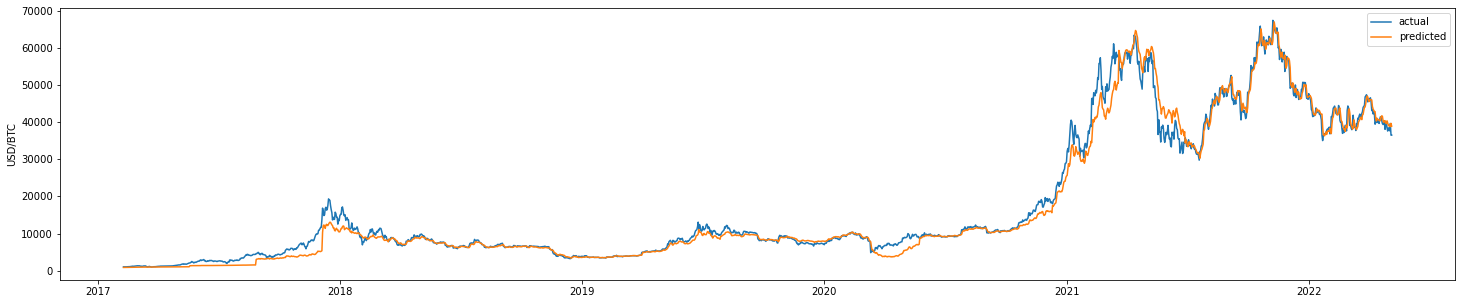

In [69]:
plt.figure(figsize=(25,5))
plt.plot(lrridge_date_array[1000:],lrridge_y_test_array[1000:],label='actual')
plt.plot(lrridge_date_array[1000:],lrridge_y_test_pred_array[1000:],label='predicted')
plt.legend()
plt.ylabel('USD/BTC')
plt.show()

In [70]:
lrridge_result_metrics_df

batch_id    mae_train   rmse_train     mae_test    rmse_test
0          0   143.422562   192.708199    68.559614    77.083808
1          1   150.298537   199.180039   188.450893   192.934919
2          2   162.756211   210.000399   243.059233   245.241879
3          3   141.935663   180.217081   141.153551   142.791345
4          4    98.110986   117.801019    82.675068    88.280968
5          5    88.690237   108.744903    68.937994    79.441870
6          6    57.919639    70.549953    88.521989    91.502956
7          7    42.430788    53.596670   220.224669   249.365822
8          8    63.685971    84.612658   182.862697   185.226746
9          9    72.107832    87.426624   288.846819   305.122116
10        10    74.739310    95.652267   307.285408   372.981043
11        11    81.181931   121.924204  1482.170089  1605.864437
12        12   206.705779   315.717034  2282.787510  2793.333635
13        13   251.999084   441.735948  2179.061367  2748.290130
14        14   317.954747   597.112276   308.473469   396.007814
15        15   360.173404   615.330809   224.635067   301.383496
16        16   389.267731   626.897408   231.192962   273.577936
17        17   409.052193   637.237798    71.628280   115.972676
18        18   369.853090   597.448879   892.465168  1095.031402
19        19   388.501735   528.959964   574.789499   714.014030
20        20   375.550344   506.365483   464.630908   542.257730
21        21   373.194641   509.453775  2084.817248  2467.255206
22        22   421.771747   550.307931   271.545193   362.822557
23        23   439.795310   587.237848  1239.048027  1719.202189
24        24   392.158486   547.791010  5194.406681  5909.811198
25        25   560.972021  1006.468193  4014.816576  4848.860347
26        26   876.367024  1434.319105  1359.909914  1787.459678
27        27  1087.723595  1603.956805  1423.182560  1874.439755
28        28  1313.935823  1786.721820  1198.428192  1646.603907
29        29  1457.833531  1891.165914  1382.895987  1693.482631

In [71]:
pd.DataFrame(lrridge_result_metrics_df.mean()).drop(['batch_id'],axis=0)

0
mae_train    372.336332
rmse_train   543.554734
mae_test     958.715421
rmse_test   1164.188141

In [72]:
pd.DataFrame(lrridge_result_metrics_df[20:].mean()).drop(['batch_id'],axis=0)

0
mae_train    729.930252
rmse_train  1042.378789
mae_test    1863.368129
rmse_test   2285.219520

In [73]:
pd.DataFrame(lrridge_result_metrics_df[27:].mean()).drop(['batch_id'],axis=0)

0
mae_train   1286.497650
rmse_train  1760.614846
mae_test    1334.835579
rmse_test   1738.175431

In [74]:
corr, _ = stats.pearsonr(lrridge_y_test_array, lrridge_y_test_pred_array)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.994


In [75]:
corr, _ = stats.pearsonr(lrridge_y_test_array[2000:], lrridge_y_test_pred_array[2000:])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.989


In [76]:
corr, _ = stats.pearsonr(lrridge_y_test_array[2600:], lrridge_y_test_pred_array[2600:])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.978


# Bayessian Ridge Regressor

In [77]:
BR_date_array = []
BR_y_test_array = []
BR_y_test_pred_array = []
BR_batch_id_array = []
BR_batch_id_array_result = []
BR_batch_mae_train_array = []
BR_batch_rmse_train_array = []
BR_batch_mae_test_array = []
BR_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    lin_reg_BR = linear_model.BayesianRidge()
    lin_reg_BR.fit(Xtrain_split, ytrain_split)


    ytrain_pred = lin_reg_BR.predict(Xtrain_split)
    ytest_pred = lin_reg_BR.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    BR_date_array.extend(test_splits[i]['Date'])
    BR_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    BR_y_test_pred_array.extend((ytest_pred.flatten()))
    BR_batch_id_array.extend([i]*len(test_splits[i]))

    BR_batch_id_array_result.append(i)
    BR_batch_mae_train_array.append(MAE_train)
    BR_batch_rmse_train_array.append(RMSE_train)
    BR_batch_mae_test_array.append(MAE_test)
    BR_batch_rmse_test_array.append(RMSE_test)

BR_result_test_df = pd.DataFrame()
BR_result_test_df['batch_id'] = BR_batch_id_array
BR_result_test_df['Date'] = BR_date_array
BR_result_test_df['y_test'] = BR_y_test_array
BR_result_test_df['y_test_pred'] = BR_y_test_pred_array
BR_y_test_array = BR_result_test_df['y_test']
BR_y_test_pred_array = BR_result_test_df['y_test_pred']

BR_result_metrics_df = pd.DataFrame()
BR_result_metrics_df['batch_id'] = BR_batch_id_array_result
BR_result_metrics_df['mae_train'] = BR_batch_mae_train_array
BR_result_metrics_df['rmse_train'] = BR_batch_rmse_train_array
BR_result_metrics_df['mae_test'] = BR_batch_mae_test_array
BR_result_metrics_df['rmse_test'] = BR_batch_rmse_test_array

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 218.12it/s]


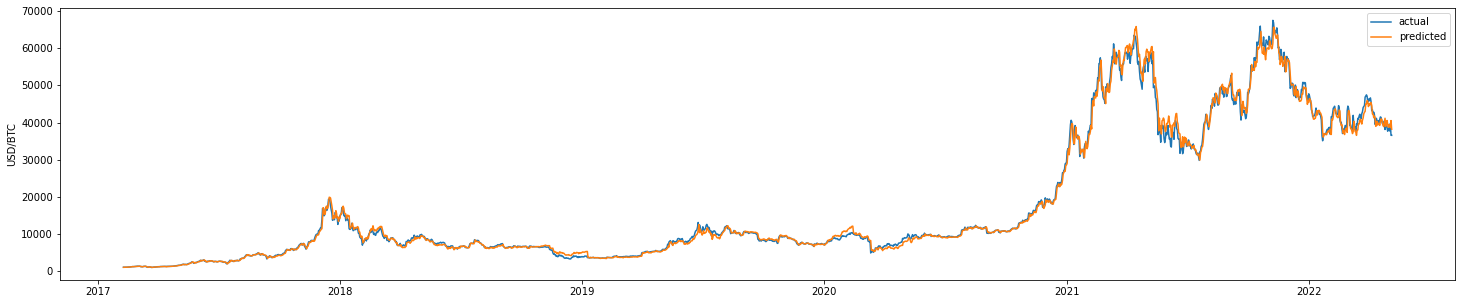

In [78]:
plt.figure(figsize=(25,5))
plt.plot(BR_date_array[1000:],BR_y_test_array[1000:],label='actual')
plt.plot(BR_date_array[1000:],BR_y_test_pred_array[1000:],label='predicted')
plt.legend()
plt.ylabel('USD/BTC')
plt.show()


In [79]:
BR_result_metrics_df

batch_id    mae_train   rmse_train     mae_test    rmse_test
0          0    20.473237    42.331968    19.364685    23.462270
1          1    21.295873    42.919987    17.240447    20.133448
2          2    21.897865    43.160167    15.972830    20.342068
3          3    22.493111    43.373327     9.536307    12.035298
4          4    13.070188    27.709252    22.233027    28.150042
5          5     7.416657    11.197739    13.414726    17.254273
6          6     6.703359    10.426836     9.500410    12.363091
7          7     6.069053     9.727104    12.758589    20.791079
8          8     6.925257    11.905594     8.325770    14.245497
9          9     7.506550    13.077305    19.762205    32.305721
10        10    10.502802    18.542144    36.881317    49.014082
11        11    14.169496    25.782958   106.247995   137.726624
12        12    35.563497    64.223692   274.209769   403.107148
13        13    78.218170   153.745730   835.331646  1069.457018
14        14   207.496627   395.124146   378.151250   456.875230
15        15   245.351098   417.375905   199.652386   250.053704
16        16   268.183324   427.312505   622.769037   756.709748
17        17   270.301985   431.841331   146.752843   186.726881
18        18   245.499700   404.529181   665.443507   826.226560
19        19   174.857811   277.131025   303.958161   389.440464
20        20   172.240589   282.196341   458.688395   683.204338
21        21   176.104844   284.597100   647.191435   804.860415
22        22   207.280798   338.794026   213.701598   287.053967
23        23   225.512742   351.167313   346.020892   519.985275
24        24   214.685825   343.343582  1571.634624  2097.067774
25        25   455.805909   845.623414  2591.782406  3150.763849
26        26   749.453100  1272.561620  1266.618795  1655.718109
27        27   936.980888  1432.761876  1620.641971  2048.714552
28        28  1150.497396  1625.203929  1266.968047  1703.146691
29        29  1273.908912  1717.150356  1433.030565  1834.125357

In [80]:
pd.DataFrame(BR_result_metrics_df.mean()).drop(['batch_id'],axis=0)

0
mae_train   241.548889
rmse_train  378.827915
mae_test    504.459521
rmse_test   650.368686

In [81]:
pd.DataFrame(BR_result_metrics_df[20:].mean()).drop(['batch_id'],axis=0)

0
mae_train    556.247100
rmse_train   849.339956
mae_test    1141.627873
rmse_test   1478.464033

In [82]:
pd.DataFrame(BR_result_metrics_df[27:].mean()).drop(['batch_id'],axis=0)

0
mae_train   1120.462399
rmse_train  1591.705387
mae_test    1440.213528
rmse_test   1861.995533

In [83]:
from scipy import stats
corr, _ = stats.pearsonr(BR_y_test_array, BR_y_test_pred_array)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.998


In [84]:
from scipy import stats
corr, _ = stats.pearsonr(BR_y_test_array[2000:], BR_y_test_pred_array[2000:])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.996


In [85]:
from scipy import stats
corr, _ = stats.pearsonr(BR_y_test_array[2600:], BR_y_test_pred_array[2600:])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.978


# LRSGD

In [86]:
lrsgd_date_array = []
lrsgd_y_test_array = []
lrsgd_y_test_pred_array = []
lrsgd_batch_id_array = []
lrsgd_batch_id_array_result = []
lrsgd_batch_mae_train_array = []
lrsgd_batch_rmse_train_array = []
lrsgd_batch_mae_test_array = []
lrsgd_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    sgd_reg = SGDRegressor(loss='squared_epsilon_insensitive',alpha=0.0001,penalty='elasticnet',shuffle=True,
                           tol=0.000001,l1_ratio=0.15,epsilon=0.01,learning_rate='adaptive',max_iter=1000,eta0 =0.01)
    sgd_reg.fit(Xtrain_split, ytrain_split)


    ytrain_pred = sgd_reg.predict(Xtrain_split)
    ytest_pred = sgd_reg.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    lrsgd_date_array.extend(test_splits[i]['Date'])
    lrsgd_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    lrsgd_y_test_pred_array.extend((ytest_pred.flatten()))
    lrsgd_batch_id_array.extend([i]*len(test_splits[i]))

    lrsgd_batch_id_array_result.append(i)
    lrsgd_batch_mae_train_array.append(MAE_train)
    lrsgd_batch_rmse_train_array.append(RMSE_train)
    lrsgd_batch_mae_test_array.append(MAE_test)
    lrsgd_batch_rmse_test_array.append(RMSE_test)

lrsgd_result_test_df = pd.DataFrame()
lrsgd_result_test_df['batch_id'] = lrsgd_batch_id_array
lrsgd_result_test_df['Date'] = lrsgd_date_array
lrsgd_result_test_df['y_test'] = lrsgd_y_test_array
lrsgd_result_test_df['y_test_pred'] = lrsgd_y_test_pred_array
lrsgd_y_test_array = lrsgd_result_test_df['y_test']
lrsgd_y_test_pred_array = lrsgd_result_test_df['y_test_pred']

lrsgd_result_metrics_df = pd.DataFrame()
lrsgd_result_metrics_df['batch_id'] = lrsgd_batch_id_array_result
lrsgd_result_metrics_df['mae_train'] = lrsgd_batch_mae_train_array
lrsgd_result_metrics_df['rmse_train'] = lrsgd_batch_rmse_train_array
lrsgd_result_metrics_df['mae_test'] = lrsgd_batch_mae_test_array
lrsgd_result_metrics_df['rmse_test'] = lrsgd_batch_rmse_test_array

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 23.15it/s]


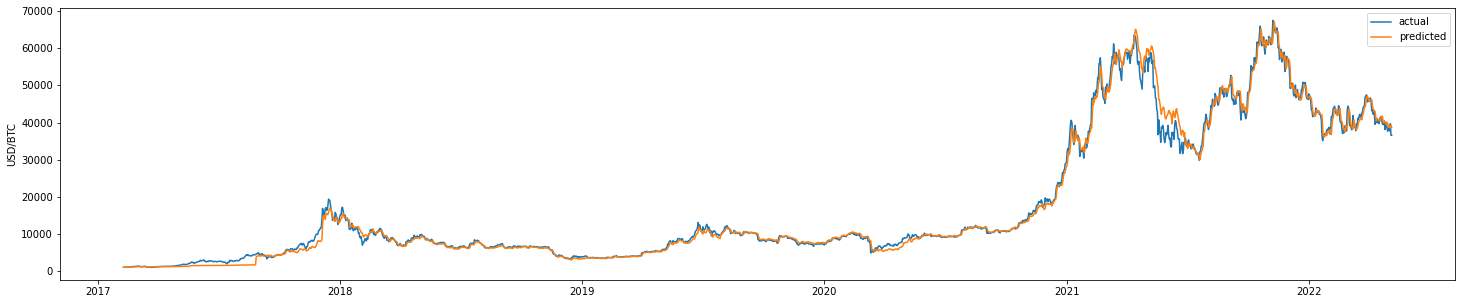

In [87]:
plt.figure(figsize=(25,5))
plt.plot(lrsgd_date_array[1000:],lrsgd_y_test_array[1000:],label='actual')
plt.plot(lrsgd_date_array[1000:],lrsgd_y_test_pred_array[1000:],label='predicted')
plt.legend()
plt.ylabel('USD/BTC')
plt.show()

In [88]:
from scipy.stats import pearsonr
corr, _ = pearsonr(lrsgd_y_test_array, lrsgd_y_test_pred_array)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.997


In [89]:
from scipy.stats import pearsonr
corr, _ = pearsonr(lrsgd_y_test_array[2000:], lrsgd_y_test_pred_array[2000:])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.994


In [90]:
from scipy.stats import pearsonr
corr, _ = pearsonr(lrsgd_y_test_array[2600:], lrsgd_y_test_pred_array[2600:])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.977


In [91]:
lrsgd_result_metrics_df

batch_id    mae_train   rmse_train     mae_test    rmse_test
0          0   116.731841   154.744831   184.639935   201.322138
1          1   114.662218   154.387025   206.233629   211.403177
2          2   112.114778   148.290644   191.792684   208.586731
3          3   118.035809   156.411027    52.632644    58.854677
4          4    80.567555   101.371891    42.909612    52.333209
5          5    66.622718    81.932604   113.513221   130.550939
6          6    54.396224    67.436909    80.097389    83.718881
7          7    36.727630    49.297833   195.134723   228.064821
8          8    46.830128    59.711925    97.511844   101.254304
9          9    49.023280    60.639242   207.236839   227.576945
10        10    62.248600    76.302579   150.336009   233.273790
11        11    79.367883   112.220801  1368.986583  1497.878012
12        12   109.772943   154.262630   957.871273  1375.442895
13        13   145.681627   240.634325   978.112079  1290.103897
14        14   255.677897   482.015632   324.799115   402.911434
15        15   291.641327   503.755355   288.145320   347.570021
16        16   319.915766   519.754758   269.233355   327.141156
17        17   329.681854   527.085139   122.613016   158.725199
18        18   304.573445   492.657905   624.366769   786.421000
19        19   224.254672   336.484030   290.002537   397.246019
20        20   227.187139   344.602303   308.235666   363.444239
21        21   214.060114   329.170144   915.019458  1059.176110
22        22   264.661648   395.834406   195.766380   264.952924
23        23   295.461734   417.187358   529.773192   749.451035
24        24   268.756515   398.142367  1776.290072  2310.103481
25        25   549.457465  1002.523410  4055.548845  4869.516955
26        26   877.486930  1449.265069  1414.355784  1851.880573
27        27  1097.256013  1622.537938  1448.823278  1888.485046
28        28  1336.394892  1817.405333  1225.582106  1677.559442
29        29  1487.313511  1929.145894  1235.095640  1491.652939

In [92]:
pd.DataFrame(lrsgd_result_metrics_df.mean()).drop(['batch_id'],axis=0)

0
mae_train   317.885472
rmse_train  472.840377
mae_test    661.688633
rmse_test   828.220066

In [93]:
pd.DataFrame(lrsgd_result_metrics_df[20:].mean()).drop(['batch_id'],axis=0)

0
mae_train    661.803596
rmse_train   970.581422
mae_test    1310.449042
rmse_test   1652.622274

In [94]:
pd.DataFrame(lrsgd_result_metrics_df[27:].mean()).drop(['batch_id'],axis=0)

0
mae_train   1306.988139
rmse_train  1789.696388
mae_test    1303.167008
rmse_test   1685.899142

# ARD Regression

In [95]:
ARD_feature_list = list(train_splits[i].drop(['next_day_closing_price','Date'],axis=1).columns)

ARD_date_array = []
ARD_y_test_array = []
ARD_y_test_pred_array = []
ARD_batch_id_array = []
ARD_batch_id_array_result = []
ARD_batch_mae_train_array = []
ARD_batch_rmse_train_array = []
ARD_batch_mae_test_array = []
ARD_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    lin_reg_ARD = linear_model.ARDRegression(
                                              alpha_1= 1.6e-06, 
                                              alpha_2= 2.6e-06, 
                                              compute_score= True, 
                                              fit_intercept= False, 
                                              lambda_1= 2.87e-06, 
                                              lambda_2= 2.87e-06, 
                                              n_iter= 365, 
                                              normalize= True, 
                                              threshold_lambda= 10000
                                              )
    lin_reg_ARD.fit(Xtrain_split, ytrain_split)


    ytrain_pred = lin_reg_ARD.predict(Xtrain_split)
    ytest_pred = lin_reg_ARD.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    ARD_date_array.extend(test_splits[i]['Date'])
    ARD_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    ARD_y_test_pred_array.extend((ytest_pred.flatten()))
    ARD_batch_id_array.extend([i]*len(test_splits[i]))

    ARD_batch_id_array_result.append(i)
    ARD_batch_mae_train_array.append(MAE_train)
    ARD_batch_rmse_train_array.append(RMSE_train)
    ARD_batch_mae_test_array.append(MAE_test)
    ARD_batch_rmse_test_array.append(RMSE_test)

ARD_result_test_df = pd.DataFrame()
ARD_result_test_df['batch_id'] = ARD_batch_id_array
ARD_result_test_df['Date'] = ARD_date_array
ARD_result_test_df['y_test'] = ARD_y_test_array
ARD_result_test_df['y_test_pred'] = ARD_y_test_pred_array
ARD_y_test_array = ARD_result_test_df['y_test']
ARD_y_test_pred_array = ARD_result_test_df['y_test_pred']

ARD_result_metrics_df = pd.DataFrame()
ARD_result_metrics_df['batch_id'] = ARD_batch_id_array_result
ARD_result_metrics_df['mae_train'] = ARD_batch_mae_train_array
ARD_result_metrics_df['rmse_train'] = ARD_batch_rmse_train_array
ARD_result_metrics_df['mae_test'] = ARD_batch_mae_test_array
ARD_result_metrics_df['rmse_test'] = ARD_batch_rmse_test_array

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.04it/s]


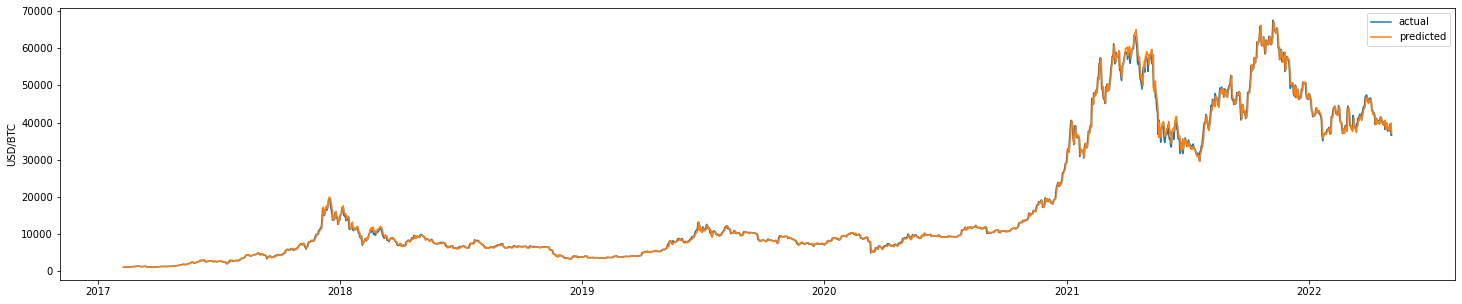

In [96]:
plt.figure(figsize=(25,5))
plt.plot(ARD_date_array[1000:],ARD_y_test_array[1000:],label='actual')
plt.plot(ARD_date_array[1000:],ARD_y_test_pred_array[1000:],label='predicted')
plt.legend()
plt.ylabel('USD/BTC')
plt.show()

In [97]:
ARD_result_metrics_df

batch_id    mae_train   rmse_train     mae_test    rmse_test
0          0    19.310989    42.349785    19.959578    23.706727
1          1    19.992813    43.036688    13.468332    16.932586
2          2    20.857944    43.335368    14.251703    18.924126
3          3    21.682064    43.576488    20.559126    22.204972
4          4    12.983041    28.351183     6.393805     8.214284
5          5     7.353031    11.298972    13.569601    17.478378
6          6     6.657805    10.440698     9.178343    12.068445
7          7     6.145461     9.840300    12.272243    20.238679
8          8     6.957981    12.002213     7.915234    14.393557
9          9     7.529091    13.247424    17.222938    31.197361
10        10    10.272051    18.541763    33.960834    46.324296
11        11    14.214754    26.041031   107.203013   138.791379
12        12    34.936077    64.537853   244.050394   370.351938
13        13    77.169957   154.632781   785.076218  1007.469094
14        14   202.350055   401.016965   230.271108   303.888021
15        15   244.617961   423.502572   182.286619   233.626628
16        16   270.156601   434.718200   141.706122   185.551303
17        17   274.014128   437.082671    66.101312   113.837801
18        18   241.257113   409.927733   386.584687   542.109118
19        19   175.068915   282.246238   217.189435   326.523601
20        20   172.443610   285.641133   174.958035   220.283451
21        21   176.251885   288.874673   312.598329   478.055965
22        22   206.634155   341.191891   167.954430   247.618152
23        23   226.432432   353.717374   297.709295   454.228782
24        24   216.995611   346.667192  1431.322215  1945.088306
25        25   461.036378   861.035579  2063.766380  2604.503970
26        26   739.401873  1284.269081  1240.982992  1663.241979
27        27   930.253278  1457.709840  1293.175880  1719.942235
28        28  1152.744890  1633.239930  1018.391463  1431.605218
29        29  1279.604966  1734.249888  1214.733766  1505.257586

In [98]:
pd.DataFrame(ARD_result_metrics_df.mean()).drop(['batch_id'],axis=0)

0
mae_train   241.177564
rmse_train  383.210784
mae_test    391.493781
rmse_test   524.121931

In [99]:
pd.DataFrame(ARD_result_metrics_df[20:].mean()).drop(['batch_id'],axis=0)

0
mae_train    556.179908
rmse_train   858.659658
mae_test     921.559278
rmse_test   1226.982564

In [100]:
pd.DataFrame(ARD_result_metrics_df[27:].mean()).drop(['batch_id'],axis=0)

0
mae_train   1120.867711
rmse_train  1608.399886
mae_test    1175.433703
rmse_test   1552.268346

In [101]:
corr, _ = pearsonr(ARD_y_test_array, ARD_y_test_pred_array)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.999


In [102]:
corr, _ = pearsonr(ARD_y_test_array[2000:], ARD_y_test_pred_array[2000:])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.997


In [103]:
corr, _ = pearsonr(ARD_y_test_array[2600:], ARD_y_test_pred_array[2600:])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.982


Feature:avg_transaction_value tema90, Score: 0.00119930793214598
Feature:ITS_9, Score: 5.6569228540400654e-05
Feature:sf_ratio sma 60, Score: 2221.9138172107755
Feature:ISA_9, Score: 9.739471381143395e-05
Feature:closing_price, Score: 60368.935795564415
Feature:MSCIACW_spot dema90, Score: 0.00022300213277268041
Feature:FUTMSCIACWI_spot ema60, Score: 0.00018458023208107042
Feature:ISB_26, Score: -1318.5259985857801
Feature:IKS_26, Score: 0.0003253549832161934
Feature:FUTBTC_spot tema3, Score: 9132.048350013287
Feature:highest_price, Score: -7.371122629993695e-06
Feature:avg_price_usd, Score: -0.00012094547418955938
Feature:lowest_price, Score: -3.614183134088659e-05
Feature:market_cap_usd, Score: -3483.0088676599808
Feature:opening_price, Score: 0.00015148436374330673
Feature:SP500_spot bband_lower7, Score: 1.1544308476208836e-05
Feature:SP500_spot stdev90, Score: -617.1818132526204
Feature:tweets_day ema3, Score: -0.00112903317999894


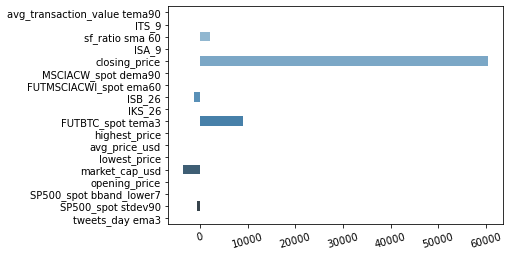

In [104]:
import seaborn as sns
importance = lin_reg_ARD.coef_
d = dict(zip(ARD_feature_list,lin_reg_ARD.coef_))
# summarize feature importance

for key,value in d.items():
    print('Feature:' + key + ", Score: " + str(value))
# plot feature importance

keys= list(d.keys())
vals = list(d.values())
plt.xticks(rotation=15)
ax = sns.barplot(x=vals, y=keys, palette="Blues_d")

# ARD only most relevant variables

In [105]:
ARD_relevant_feature_list = ['sf_ratio sma 60','closing_price','ISB_26','FUTBTC_spot tema3','market_cap_usd']


ARD_relevant_date_array = []
ARD_relevant_y_test_array = []
ARD_relevant_y_test_pred_array = []
ARD_relevant_batch_id_array = []
ARD_relevant_batch_id_array_result = []
ARD_relevant_batch_mae_train_array = []
ARD_relevant_batch_rmse_train_array = []
ARD_relevant_batch_mae_test_array = []
ARD_relevant_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i][ARD_relevant_feature_list]
    Xtest_split = test_splits[i][ARD_relevant_feature_list]
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    lin_reg_ARD_relevant = linear_model.ARDRegression(alpha_1= 1.6e-06, 
                                              alpha_2= 2.6e-06, 
                                              compute_score= True, 
                                              fit_intercept= False, 
                                              lambda_1= 2.87e-06, 
                                              lambda_2= 2.87e-06, 
                                              n_iter= 365, 
                                              normalize= True, 
                                              threshold_lambda= 10000)
    lin_reg_ARD_relevant.fit(Xtrain_split, ytrain_split)


    ytrain_pred = lin_reg_ARD_relevant.predict(Xtrain_split)
    ytest_pred = lin_reg_ARD_relevant.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    ARD_relevant_date_array.extend(test_splits[i]['Date'])
    ARD_relevant_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    ARD_relevant_y_test_pred_array.extend((ytest_pred.flatten()))
    ARD_relevant_batch_id_array.extend([i]*len(test_splits[i]))

    ARD_relevant_batch_id_array_result.append(i)
    ARD_relevant_batch_mae_train_array.append(MAE_train)
    ARD_relevant_batch_rmse_train_array.append(RMSE_train)
    ARD_relevant_batch_mae_test_array.append(MAE_test)
    ARD_relevant_batch_rmse_test_array.append(RMSE_test)

ARD_relevant_result_test_df = pd.DataFrame()
ARD_relevant_result_test_df['batch_id'] = ARD_relevant_batch_id_array
ARD_relevant_result_test_df['Date'] = ARD_relevant_date_array
ARD_relevant_result_test_df['y_test'] = ARD_relevant_y_test_array
ARD_relevant_result_test_df['y_test_pred'] = ARD_relevant_y_test_pred_array
ARD_relevant_y_test_array = ARD_relevant_result_test_df['y_test']
ARD_relevant_y_test_pred_array = ARD_relevant_result_test_df['y_test_pred']

ARD_relevant_result_metrics_df = pd.DataFrame()
ARD_relevant_result_metrics_df['batch_id'] = ARD_relevant_batch_id_array_result
ARD_relevant_result_metrics_df['mae_train'] = ARD_relevant_batch_mae_train_array
ARD_relevant_result_metrics_df['rmse_train'] = ARD_relevant_batch_rmse_train_array
ARD_relevant_result_metrics_df['mae_test'] = ARD_relevant_batch_mae_test_array
ARD_relevant_result_metrics_df['rmse_test'] = ARD_relevant_batch_rmse_test_array



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.77it/s]


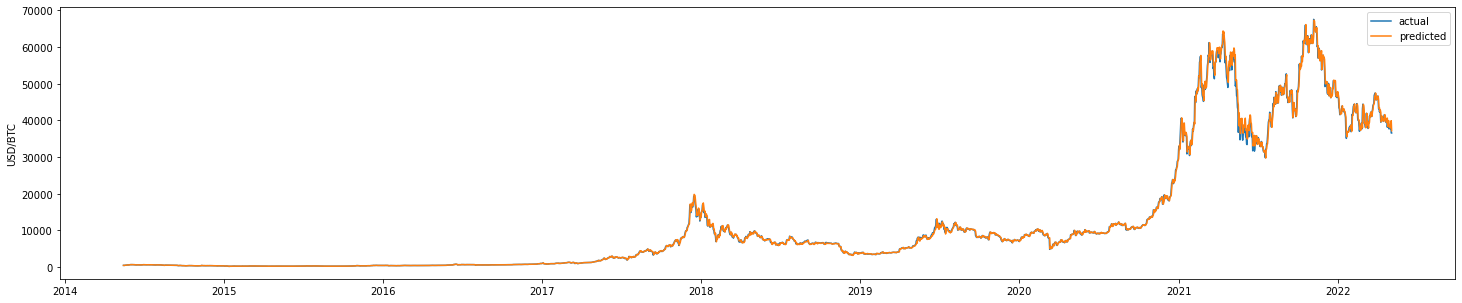

In [106]:
plt.figure(figsize=(25,5))
plt.plot(ARD_relevant_date_array,ARD_relevant_y_test_array,label='actual')
plt.plot(ARD_relevant_date_array,ARD_relevant_y_test_pred_array,label='predicted')
plt.legend()
plt.ylabel('USD/BTC')
plt.show()

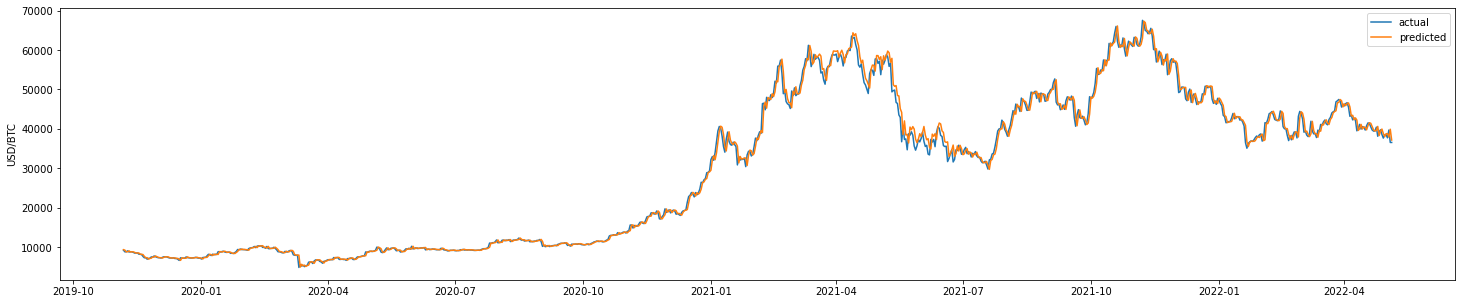

In [107]:
plt.figure(figsize=(25,5))
plt.plot(ARD_relevant_date_array[2000:],ARD_relevant_y_test_array[2000:],label='actual')
plt.plot(ARD_relevant_date_array[2000:],ARD_relevant_y_test_pred_array[2000:],label='predicted')
plt.legend()
plt.ylabel('USD/BTC')
plt.show()

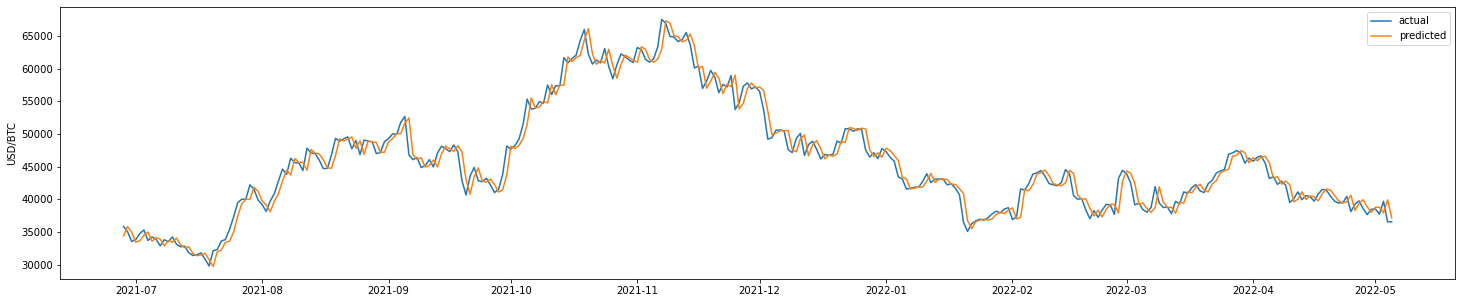

In [108]:
plt.figure(figsize=(25,5))
plt.plot(ARD_relevant_date_array[2600:],ARD_relevant_y_test_array[2600:],label='actual')
plt.plot(ARD_relevant_date_array[2600:],ARD_relevant_y_test_pred_array[2600:],label='predicted')
plt.legend()
plt.ylabel('USD/BTC')
plt.show()

In [109]:
ARD_relevant_result_metrics_df

batch_id    mae_train   rmse_train     mae_test    rmse_test
0          0    19.119950    43.428941    11.890160    16.394493
1          1    19.925403    43.769065    11.574282    15.266444
2          2    20.714174    44.104322    12.461534    16.345779
3          3    21.527160    44.549051     7.021999     8.546684
4          4    12.800144    29.271994     5.623632     7.263550
5          5     7.372250    11.513778     9.198165    13.020928
6          6     6.738781    10.516163     9.725250    12.448540
7          7     6.377393    10.025706    12.289160    19.915797
8          8     7.063138    12.101055     7.059039    14.270737
9          9     7.748892    13.443839    17.300418    30.529958
10        10    10.376731    18.932018    30.076155    43.188440
11        11    14.164224    26.118398   106.445692   138.276251
12        12    34.766403    66.519474   219.134396   333.274754
13        13    76.583376   157.904613   705.579303   926.827313
14        14   202.900166   406.279466   229.570407   303.782650
15        15   244.740707   428.146044   176.415142   227.780098
16        16   270.978185   438.449870   138.905045   182.944215
17        17   273.844974   439.508161    68.268402   112.368986
18        18   242.999166   413.595044   395.476074   551.063354
19        19   175.567654   283.813411   217.895768   324.086149
20        20   173.776091   288.563569   159.803215   216.105083
21        21   177.213519   290.837155   264.648488   448.936697
22        22   207.049588   344.264002   170.978163   248.402445
23        23   228.474571   357.969322   291.816437   444.882315
24        24   217.792566   348.122325  1419.978626  1923.743727
25        25   469.504231   892.198208  2003.263043  2560.225017
26        26   747.141367  1314.959555  1189.120385  1574.069490
27        27   933.526744  1472.548619  1297.890314  1725.242712
28        28  1161.771336  1653.582942   970.412376  1382.884707
29        29  1281.473902  1737.295607  1221.354300  1509.397093

In [110]:
pd.DataFrame(ARD_relevant_result_metrics_df.mean()).drop(['batch_id'],axis=0)

0
mae_train   242.467759
rmse_train  388.077724
mae_test    379.372512
rmse_test   511.049480

In [111]:
pd.DataFrame(ARD_relevant_result_metrics_df[20:].mean()).drop(['batch_id'],axis=0)

0
mae_train    559.772391
rmse_train   870.034130
mae_test     898.926535
rmse_test   1203.388929

In [112]:
pd.DataFrame(ARD_relevant_result_metrics_df[27:].mean()).drop(['batch_id'],axis=0)

0
mae_train   1125.590661
rmse_train  1621.142389
mae_test    1163.218997
rmse_test   1539.174837

In [113]:
corr, _ = pearsonr(ARD_relevant_y_test_array, ARD_relevant_y_test_pred_array)
print('Pearsons correlation: %.4f' % corr)

Pearsons correlation: 0.9988


In [114]:
corr, _ = pearsonr(ARD_relevant_y_test_array[2000:], ARD_relevant_y_test_pred_array[2000:])
print('Pearsons correlation: %.4f' % corr)

Pearsons correlation: 0.9973


In [115]:
corr, _ = pearsonr(ARD_relevant_y_test_array[2600:], ARD_relevant_y_test_pred_array[2600:])
print('Pearsons correlation: %.4f' % corr)

Pearsons correlation: 0.9825


Feature:sf_ratio sma 60, Score: 1893.6739628707262
Feature:closing_price, Score: 60676.38862426461
Feature:ISB_26, Score: -1204.2428910028402
Feature:FUTBTC_spot tema3, Score: 9466.801442276419
Feature:market_cap_usd, Score: -4026.7437000228892


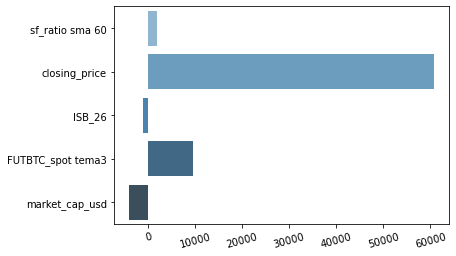

In [116]:

importance = lin_reg_ARD_relevant.coef_
d = dict(zip(ARD_relevant_feature_list,lin_reg_ARD_relevant.coef_))
# summarize feature importance

for key,value in d.items():
    print('Feature:' + key + ", Score: " + str(value))
# plot feature importance

keys= list(d.keys())
vals = list(d.values())
plt.xticks(rotation=15)
ax = sns.barplot(x=vals, y=keys, palette="Blues_d")

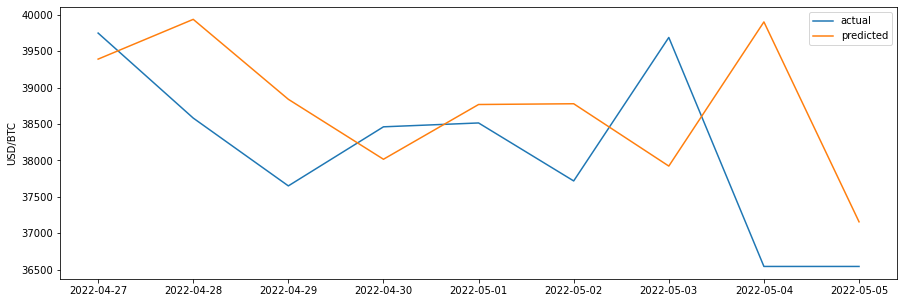

In [117]:
plt.figure(figsize=(15,5))
plt.plot(ARD_relevant_date_array[2903:],ARD_relevant_y_test_array[2903:],label='actual')
plt.plot(ARD_relevant_date_array[2903:],ARD_relevant_y_test_pred_array[2903:],label='predicted')
plt.legend()
plt.ylabel('USD/BTC')
plt.show()

In [118]:
ARD_relevant_y_test_array.values[-2:]

array([36544., 36544.])

# ARD most relevant 2nd phase

In [119]:
ARD_relevant2_feature_list= ['closing_price'
                             ,'FUTBTC_spot tema3'
                             ,'sf_ratio sma 60' 
                             #,'market_cap_usd'
                             ,'ISB_26'
                            ]

ARD_relevant2_date_array = []
ARD_relevant2_y_test_array = []
ARD_relevant2_y_test_pred_array = []
ARD_relevant2_batch_id_array = []
ARD_relevant2_batch_id_array_result = []
ARD_relevant2_batch_mae_train_array = []
ARD_relevant2_batch_rmse_train_array = []
ARD_relevant2_batch_mae_test_array = []
ARD_relevant2_batch_rmse_test_array = []

for i in tqdm(range(len(train_splits))):
    Xtrain_split = train_splits[i][ARD_relevant2_feature_list]
    Xtest_split = test_splits[i][ARD_relevant2_feature_list]
    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values

    lin_reg_ARD_relevant2 = linear_model.ARDRegression(alpha_1= 1.6e-06, 
                                              alpha_2= 2.6e-06, 
                                              compute_score= True, 
                                              fit_intercept= False, 
                                              lambda_1= 2.87e-06, 
                                              lambda_2= 2.87e-06, 
                                              n_iter= 365, 
                                              normalize= True, 
                                              threshold_lambda= 10000)
    lin_reg_ARD_relevant2.fit(Xtrain_split, ytrain_split)


    ytrain_pred = lin_reg_ARD_relevant2.predict(Xtrain_split)
    ytest_pred = lin_reg_ARD_relevant2.predict(Xtest_split)

    MAE_train,RMSE_train = calculate_metrics(ytrain_split,ytrain_pred)
    MAE_test,RMSE_test = calculate_metrics(ytest_split,ytest_pred)

    ARD_relevant2_date_array.extend(test_splits[i]['Date'])
    ARD_relevant2_y_test_array.extend(test_splits[i]['next_day_closing_price'])
    ARD_relevant2_y_test_pred_array.extend((ytest_pred.flatten()))
    ARD_relevant2_batch_id_array.extend([i]*len(test_splits[i]))

    ARD_relevant2_batch_id_array_result.append(i)
    ARD_relevant2_batch_mae_train_array.append(MAE_train)
    ARD_relevant2_batch_rmse_train_array.append(RMSE_train)
    ARD_relevant2_batch_mae_test_array.append(MAE_test)
    ARD_relevant2_batch_rmse_test_array.append(RMSE_test)

ARD_relevant2_result_test_df = pd.DataFrame()
ARD_relevant2_result_test_df['batch_id'] = ARD_relevant2_batch_id_array
ARD_relevant2_result_test_df['Date'] = ARD_relevant2_date_array
ARD_relevant2_result_test_df['y_test'] = ARD_relevant2_y_test_array
ARD_relevant2_result_test_df['y_test_pred'] = ARD_relevant2_y_test_pred_array
ARD_relevant2_y_test_array = ARD_relevant2_result_test_df['y_test']
ARD_relevant2_y_test_pred_array = ARD_relevant2_result_test_df['y_test_pred']

ARD_relevant2_result_metrics_df = pd.DataFrame()
ARD_relevant2_result_metrics_df['batch_id'] = ARD_relevant2_batch_id_array_result
ARD_relevant2_result_metrics_df['mae_train'] = ARD_relevant2_batch_mae_train_array
ARD_relevant2_result_metrics_df['rmse_train'] = ARD_relevant2_batch_rmse_train_array
ARD_relevant2_result_metrics_df['mae_test'] = ARD_relevant2_batch_mae_test_array
ARD_relevant2_result_metrics_df['rmse_test'] = ARD_relevant2_batch_rmse_test_array



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 118.50it/s]


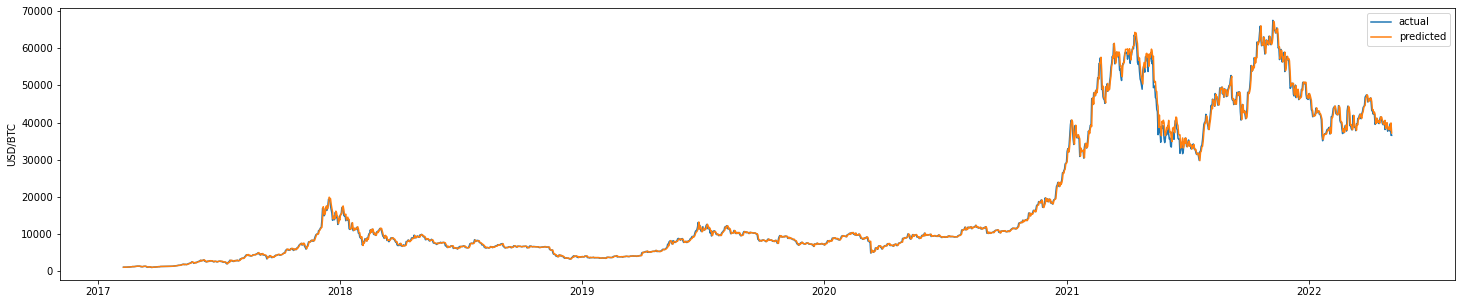

In [120]:
plt.figure(figsize=(25,5))
plt.plot(ARD_relevant2_date_array[1000:],ARD_relevant2_y_test_array[1000:],label='actual')
plt.plot(ARD_relevant2_date_array[1000:],ARD_relevant2_y_test_pred_array[1000:],label='predicted')
plt.legend()
plt.ylabel('USD/BTC')

plt.show()


In [121]:
corr, _ = pearsonr(ARD_relevant2_y_test_array[2000:], ARD_relevant2_y_test_pred_array[2000:])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.997


In [122]:
ARD_relevant2_result_metrics_df

batch_id    mae_train   rmse_train     mae_test    rmse_test
0          0    19.119949    43.428941    11.890159    16.394492
1          1    19.925402    43.769065    11.574280    15.266442
2          2    20.714174    44.104322    12.461534    16.345780
3          3    21.527160    44.549051     7.021999     8.546684
4          4    12.757807    29.429624     5.153667     6.877651
5          5     7.382982    11.599703     8.224860    12.588061
6          6     6.738781    10.516163     9.725250    12.448540
7          7     6.596069    10.164751    12.748042    20.105909
8          8     7.338316    12.260974     7.493902    14.036254
9          9     7.946908    13.520300    16.923241    30.340939
10        10    10.376731    18.932018    30.076155    43.188440
11        11    14.164224    26.118398   106.445692   138.276251
12        12    34.766403    66.519474   219.134397   333.274754
13        13    76.658262   158.152569   703.251090   920.259947
14        14   203.241761   416.535843   222.242728   299.519842
15        15   244.314806   437.257484   151.864562   208.389366
16        16   267.907626   446.221846   112.860933   175.855846
17        17   269.465789   448.937939    61.644179   108.091015
18        18   236.698790   423.358303   345.427350   498.262490
19        19   176.661488   284.731584   215.206760   320.513529
20        20   173.776091   288.563569   159.803215   216.105082
21        21   177.431177   291.018711   264.714767   449.152399
22        22   207.162607   344.334882   171.526191   248.941348
23        23   229.531224   358.540962   298.105840   449.512605
24        24   222.205481   350.570287  1410.432208  1914.724434
25        25   467.489076   894.608651  2025.961911  2573.335460
26        26   747.141366  1314.959551  1189.120391  1574.069496
27        27   932.611903  1475.723749  1297.219337  1729.629189
28        28  1162.539132  1655.175680   971.297896  1385.537718
29        29  1282.362497  1740.569672  1202.230974  1494.139661

In [123]:
pd.DataFrame(ARD_relevant2_result_metrics_df[27:].mean()).drop(['batch_id'],axis=0)

0
mae_train   1125.837844
rmse_train  1623.823034
mae_test    1156.916069
rmse_test   1536.435523

Feature:closing_price, Score: 59329.37656106963
Feature:FUTBTC_spot tema3, Score: 6856.153277961555
Feature:sf_ratio sma 60, Score: 1911.280361901263
Feature:ISB_26, Score: -1283.4863422355659


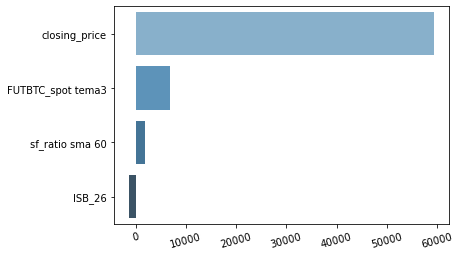

In [124]:
import seaborn as sns
importance = lin_reg_ARD_relevant2.coef_
d = dict(zip(ARD_relevant2_feature_list,lin_reg_ARD_relevant2.coef_))
# summarize feature importance

for key,value in d.items():
    print('Feature:' + key + ", Score: " + str(value))
# plot feature importance

keys= list(d.keys())
vals = list(d.values())
plt.xticks(rotation=15)
ax.bar_label(ax.containers[0])

ax = sns.barplot(x=vals, y=keys, palette="Blues_d")

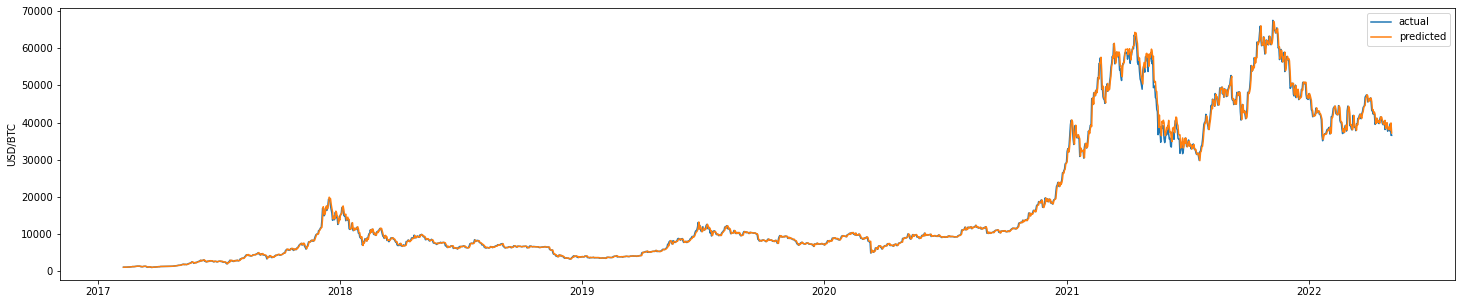

In [125]:
plt.figure(figsize=(25,5))
plt.plot(ARD_relevant2_date_array[1000:],ARD_relevant2_y_test_array[1000:],label='actual')
plt.plot(ARD_relevant2_date_array[1000:],ARD_relevant2_y_test_pred_array[1000:],label='predicted')
plt.legend()
plt.ylabel('USD/BTC')

plt.show()

Text(0, 0.5, 'USD/BTC')

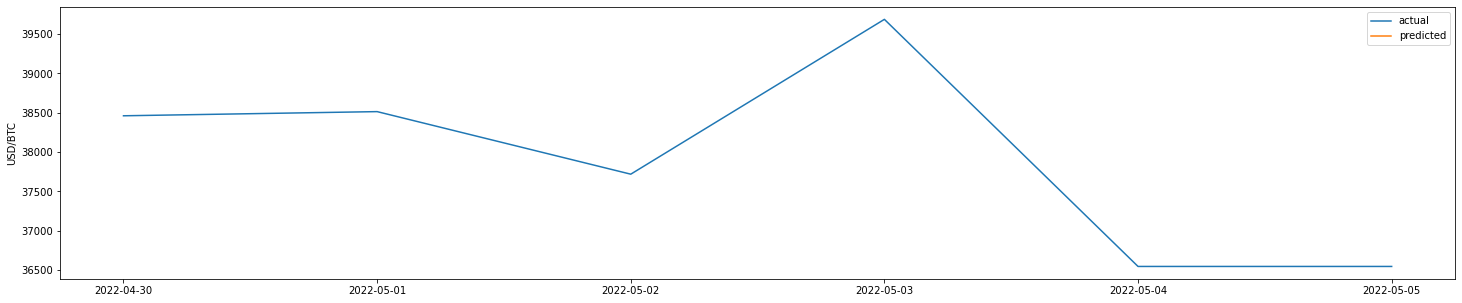

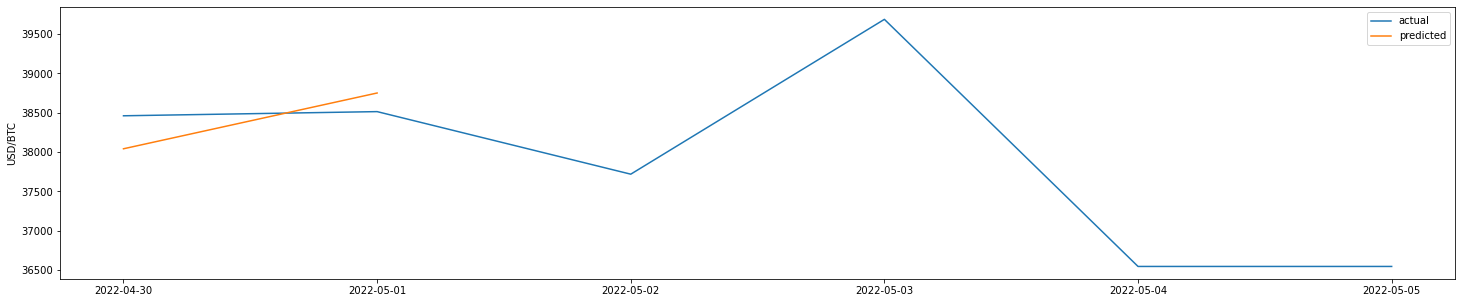

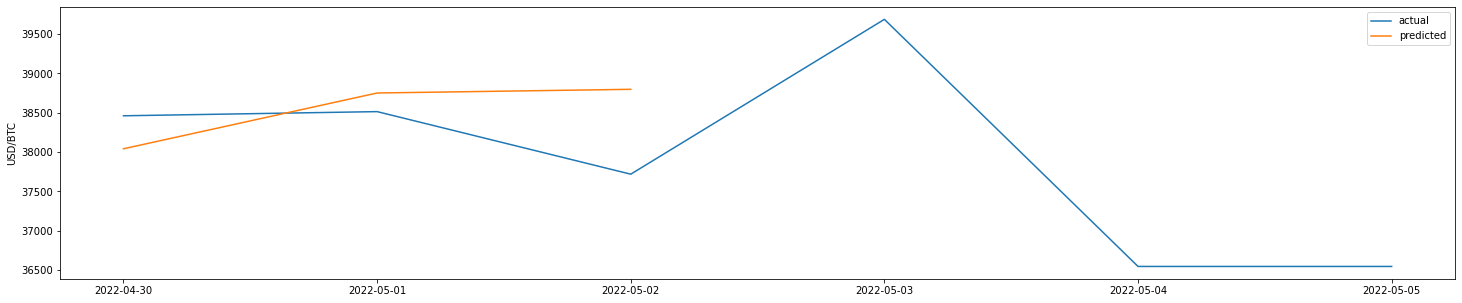

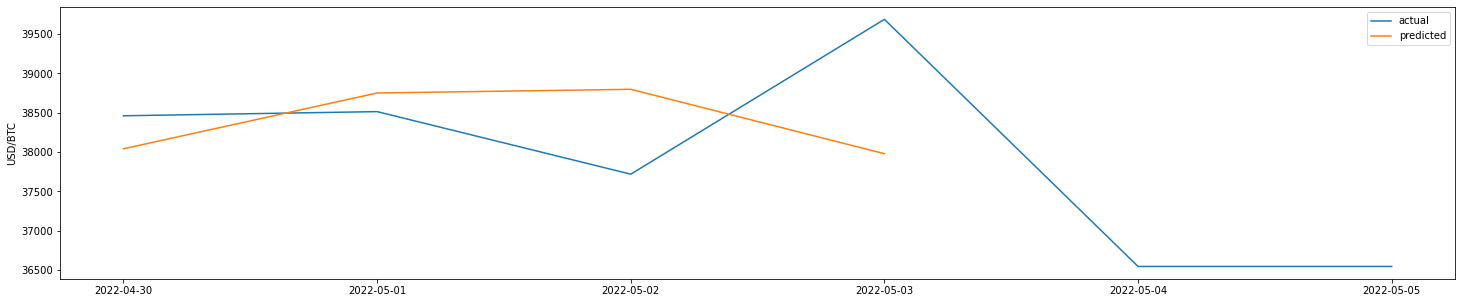

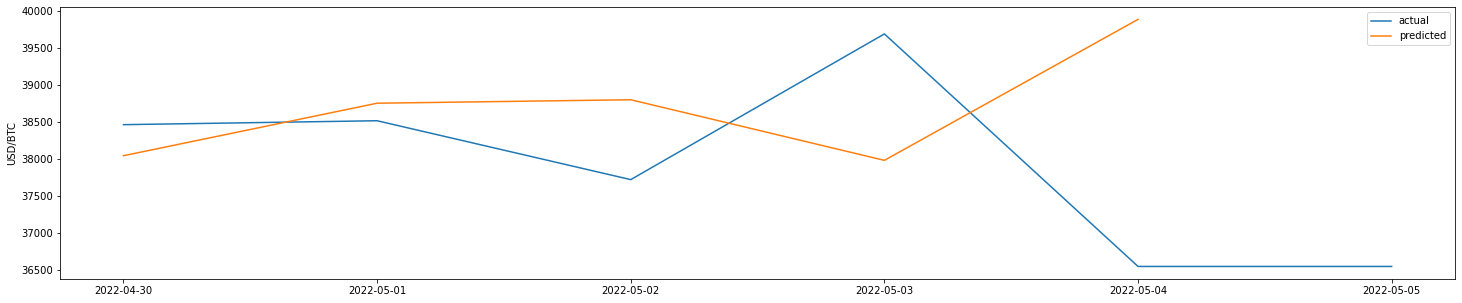

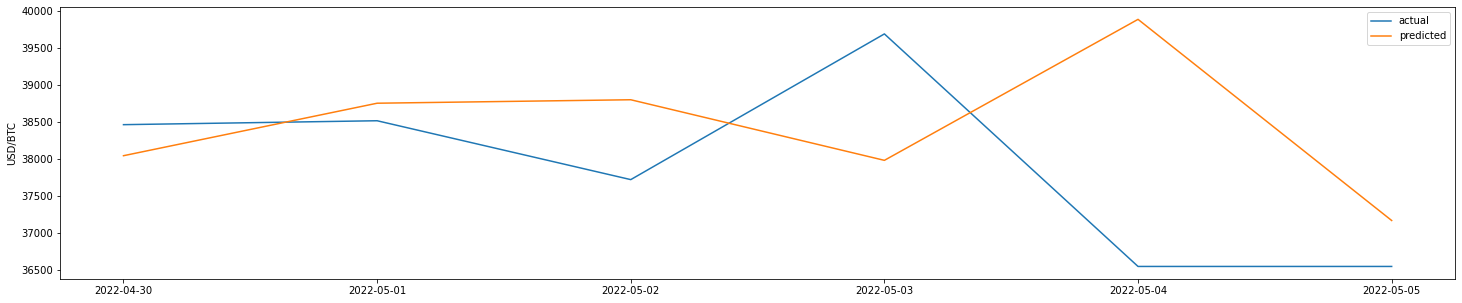

In [126]:
days = 6
end_point = len(ARD_relevant2_y_test_array)
starting_point = len(ARD_relevant2_y_test_array)-days

for x in range(1,days):
    plt.figure(figsize=(25,5))
    plt.plot(ARD_relevant2_date_array[starting_point:end_point],ARD_relevant2_y_test_array[starting_point:end_point],label='actual')
    plt.plot(ARD_relevant2_date_array[starting_point:end_point-days+x],ARD_relevant2_y_test_pred_array[starting_point:end_point-days+x],label='predicted')
    plt.legend()
    plt.ylabel('USD/BTC')

plt.figure(figsize=(25,5))
plt.plot(ARD_relevant2_date_array[starting_point:end_point],ARD_relevant2_y_test_array[starting_point:end_point],label='actual')
plt.plot(ARD_relevant2_date_array[starting_point:end_point-days+x+1],ARD_relevant2_y_test_pred_array[starting_point:end_point-days+x+1],label='predicted')
plt.legend()
plt.ylabel('USD/BTC')  


# Gridsearch CV

In [127]:
#parameter grid - Don't run like this, parameters options need to be reduced

#parameters = {
#    'n_iter' : [400, 450, 500], 
#    'alpha_1': [1.5e-6,1.5e-9,1.9e-6 ],
#    'alpha_2': [1e-6, 2e-6, 1.5e-6,1.9e-6, 3e-6],
#    'lambda_1': [1e-6, 2e-6, 1.5e-6,1.9e-6, 3e-6],
#    'lambda_2' : [1e-6, 2e-6, 1.5e-6,1.9e-6, 3e-6],
#    'compute_score' : [True,False],
#    'threshold_lambda' : [10000, 9000, 8000, 7000, 11000],
#    'fit_intercept' : [True, False],
#    'normalize' : [True, False]
#}



In [128]:
#periods_for_grid = 3 # 1200 days so that we take latest period
##
##
#GRID_date_array = []
#GRID_y_test_array = []
#GRID_y_test_pred_array = []
#GRID_batch_id_array = []
#GRID_batch_id_array_result = []
#GRID_batch_best_params_array = []
#GRID_batch_best_score_array = []
#GRID_batch_mae_test_array = []
#GRID_batch_rmse_test_array = []
#
#for i in tqdm(range(len(train_splits)-periods_for_grid,len(train_splits),1)):
#    Xtrain_split = train_splits[i].drop(['next_day_closing_price','Date'],axis=1)
#    Xtest_split = test_splits[i].drop(['next_day_closing_price','Date'],axis=1)
#    ytrain_split = train_splits[i]['next_day_closing_price'].reset_index(drop=True).values
#    ytest_split = test_splits[i]['next_day_closing_price'].reset_index(drop=True).values
#
#    lin_reg_GRID = GridSearchCV(lin_reg_ARD,                    # model
#                   param_grid = parameters,   # hyperparameters
#                   scoring='neg_root_mean_squared_error',        # metric for scoring
#                   cv=10)                     # number of folds
#    lin_reg_GRID.fit(Xtrain_split, ytrain_split)
#
#
#    ytrain_pred = lin_reg_GRID.predict(Xtrain_split)
#    ytest_pred = lin_reg_GRID.predict(Xtest_split)
#
#    GRID_date_array.extend(test_splits[i]['Date'])
#    GRID_y_test_array.extend(test_splits[i]['next_day_closing_price'])
#    GRID_y_test_pred_array.extend((ytest_pred.flatten()))
#    GRID_batch_id_array.extend([i]*len(test_splits[i]))
#
#    GRID_batch_id_array_result.append(i)
#    GRID_batch_best_params_array.append(lin_reg_GRID.best_params_)
#    GRID_batch_best_score_array.append(lin_reg_GRID.best_score_)
#    
#
#GRID_result_test_df = pd.DataFrame()
#GRID_result_test_df['batch_id'] = GRID_batch_id_array
#GRID_result_test_df['Date'] = GRID_date_array
#GRID_result_test_df['y_test'] = GRID_y_test_array
#GRID_result_test_df['y_test_pred'] = GRID_y_test_pred_array
#GRID_y_test_array = GRID_result_test_df['y_test']
#GRID_y_test_pred_array = GRID_result_test_df['y_test_pred']
#
#GRID_result_metrics_df = pd.DataFrame()
#GRID_result_metrics_df['batch_id'] = GRID_batch_id_array_result
#GRID_result_metrics_df['best_params'] = GRID_batch_best_params_array
#GRID_result_metrics_df['best_scores'] = GRID_batch_best_score_array
#GRID_result_metrics_df['best_params'] = GRID_batch_best_params_array
#GRID_result_metrics_df['best_scores'] = GRID_batch_best_score_array

In [129]:
#pd.options.display.max_colwidth=None
#
#GRID_result_metrics_df

## OUTPUT

In [130]:
last_prediction = ARD_relevant2_y_test_pred_array.values[-1]

In [131]:
print(str(prediction_day) + ' predicted closing price : ' +" {:.2f}".format(last_prediction) + ' USD')

06/05/2022 predicted closing price :  37165.24 USD
